In [1]:
# 1.1 - Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from collections import Counter
from wordcloud import WordCloud
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Set styling for visualizations
plt.style.use('fivethirtyeight')
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

# Enable all plotly visualizations to show in the notebook
import plotly.io as pio
pio.renderers.default = "notebook"

# For reproducibility
import random
np.random.seed(42)
random.seed(42)

In [2]:
# 1.2 - Download and Prepare NLTK Resources
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# Load the IMDB Dataset directly (if already in Kaggle environment)
imdb_data = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')

In [4]:
# 1.4 - Exploratory Data Analysis
# Display basic information about the dataset
print("Dataset Shape:", imdb_data.shape)
print("\nDataset Info:")
imdb_data.info()
print("\nFirst few rows of the dataset:")
display(imdb_data.head())

# Check for missing values
print("\nMissing values in each column:")
print(imdb_data.isnull().sum())

# Check the class distribution
print("\nClass distribution:")
sentiment_counts = imdb_data['sentiment'].value_counts()
print(sentiment_counts)
print(f"Positive reviews: {sentiment_counts['positive']} ({sentiment_counts['positive']/len(imdb_data)*100:.2f}%)")
print(f"Negative reviews: {sentiment_counts['negative']} ({sentiment_counts['negative']/len(imdb_data)*100:.2f}%)")

Dataset Shape: (50000, 2)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB

First few rows of the dataset:


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive



Missing values in each column:
review       0
sentiment    0
dtype: int64

Class distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64
Positive reviews: 25000 (50.00%)
Negative reviews: 25000 (50.00%)


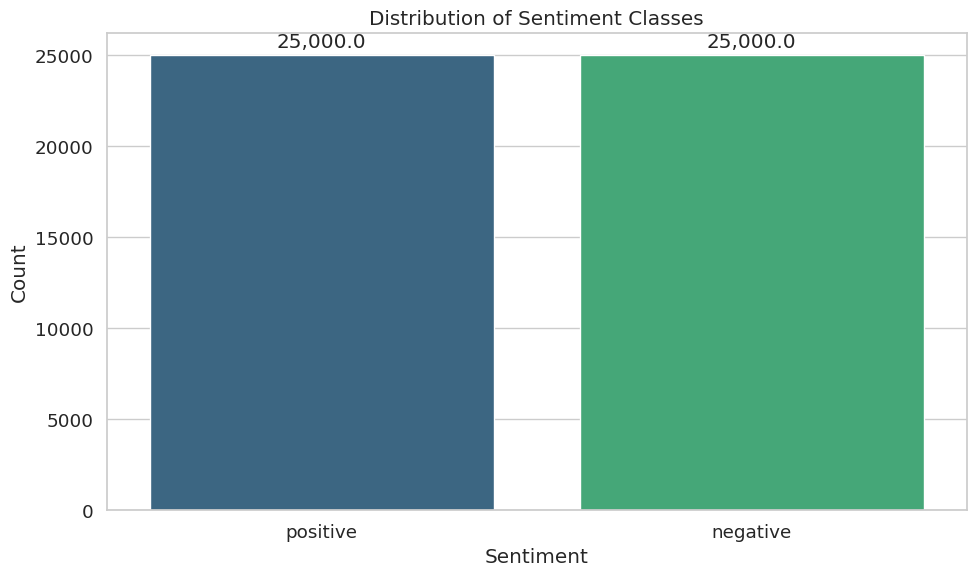

In [5]:
# 1.5 - Visualize Class Distribution
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='sentiment', data=imdb_data, palette='viridis')
plt.title('Distribution of Sentiment Classes')
plt.xlabel('Sentiment')
plt.ylabel('Count')

# Add count labels
for p in ax.patches:
    ax.annotate(f'{p.get_height():,}', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')

plt.tight_layout()
plt.savefig('sentiment_distribution.png')
plt.show()

Review length (characters):
Min: 32
Max: 13704

Word count:
Min: 4
Max: 2470


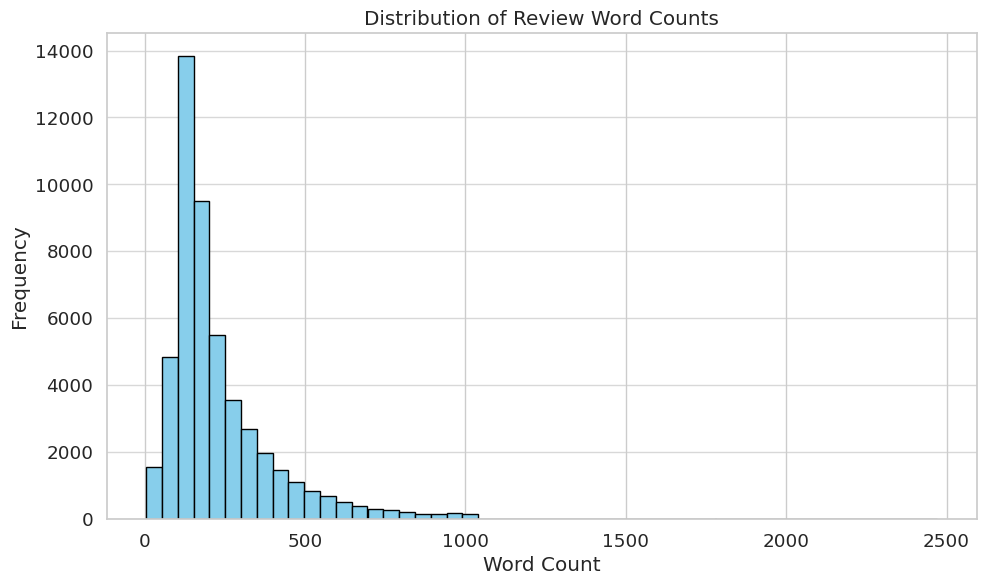

In [6]:
# 1.6 - Basic Review Length Information
# Add columns for review length and word count
imdb_data['review_length'] = imdb_data['review'].apply(len)
imdb_data['word_count'] = imdb_data['review'].apply(lambda x: len(x.split()))

# Print simple length statistics
print("Review length (characters):")
print(f"Min: {imdb_data['review_length'].min()}")
print(f"Max: {imdb_data['review_length'].max()}")

print("\nWord count:")
print(f"Min: {imdb_data['word_count'].min()}")
print(f"Max: {imdb_data['word_count'].max()}")

# Simple histogram of word counts
plt.figure(figsize=(10, 6))
plt.hist(imdb_data['word_count'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Review Word Counts')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.savefig('word_count_distribution.png')
plt.show()

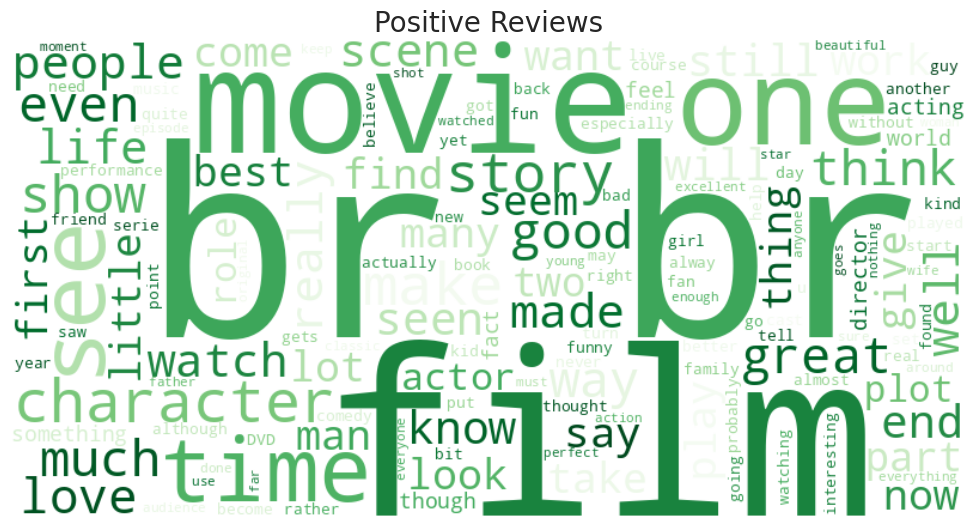

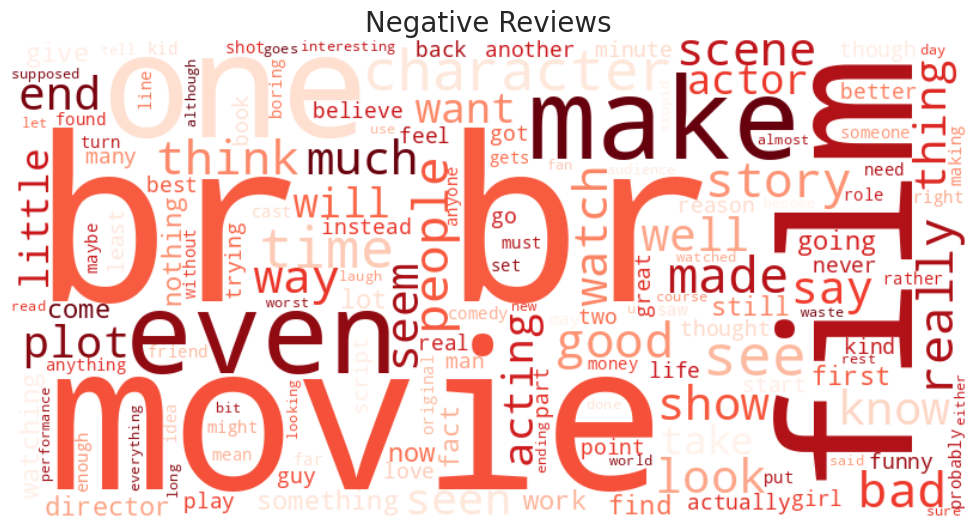

In [7]:
# 1.7 - Create Word Clouds for Positive and Negative Reviews
# Function to generate a word cloud
def generate_wordcloud(text, title, color='viridis'):
    wordcloud = WordCloud(width=800, height=400, 
                         background_color='white',
                         colormap=color,
                         max_words=150,
                         contour_width=3,
                         contour_color='steelblue')
    wordcloud.generate(text)
    
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=20)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(f'{title.lower().replace(" ", "_")}.png')
    plt.show()

# Generate word clouds for each sentiment
positive_reviews = ' '.join(imdb_data[imdb_data['sentiment'] == 'positive']['review'])
negative_reviews = ' '.join(imdb_data[imdb_data['sentiment'] == 'negative']['review'])

generate_wordcloud(positive_reviews, 'Positive Reviews', 'Greens')
generate_wordcloud(negative_reviews, 'Negative Reviews', 'Reds')

In [8]:
# 1.8 - Data Split and Setup for the Next Steps
from sklearn.model_selection import train_test_split

# Map sentiments to binary labels (0 for negative, 1 for positive)
imdb_data['sentiment_label'] = imdb_data['sentiment'].map({'negative': 0, 'positive': 1})

# Split the data into training and testing sets (stratified to maintain class distribution)
X_train, X_test, y_train, y_test = train_test_split(
    imdb_data['review'], 
    imdb_data['sentiment_label'], 
    test_size=0.2, 
    random_state=42,
    stratify=imdb_data['sentiment_label']
)

# Further split training data to create a validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train, 
    y_train, 
    test_size=0.25,  # 0.25 x 0.8 = 0.2 of original data
    random_state=42,
    stratify=y_train
)

# Print split information
print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")

# Verify class balance
print("\nClass distribution:")
print(f"Training - Positive: {sum(y_train == 1)} ({sum(y_train == 1)/len(y_train)*100:.1f}%)")
print(f"Validation - Positive: {sum(y_val == 1)} ({sum(y_val == 1)/len(y_val)*100:.1f}%)")
print(f"Test - Positive: {sum(y_test == 1)} ({sum(y_test == 1)/len(y_test)*100:.1f}%)")

Training set: 30000 samples
Validation set: 10000 samples
Test set: 10000 samples

Class distribution:
Training - Positive: 15000 (50.0%)
Validation - Positive: 5000 (50.0%)
Test - Positive: 5000 (50.0%)


In [9]:
# 2.1 - Define Text Cleaning Function
import re
import string

def clean_text(text):
    """
    Basic cleaning of texts.
    
    Args:
        text (str): Text to be cleaned
        
    Returns:
        str: Cleaned text
    """
    # Convert to lowercase
    text = text.lower()
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Test the cleaning function on a sample
sample_review = X_train.iloc[0]
print("Original review (first 300 characters):")
print(sample_review[:300], "...\n")

cleaned_sample = clean_text(sample_review)
print("After cleaning (first 300 characters):")
print(cleaned_sample[:300], "...")

Original review (first 300 characters):
The Shining, you know what's weird about this movie? This is the movie that everyone, for people who claim to not like horror films, will always say that The Shining is a terrific film. This is Stanley Kubrick's classic vision of Stephen King's horror tale of madness and blood. This is just an incre ...

After cleaning (first 300 characters):
the shining you know whats weird about this movie this is the movie that everyone for people who claim to not like horror films will always say that the shining is a terrific film this is stanley kubricks classic vision of stephen kings horror tale of madness and blood this is just an incredible fil ...


In [10]:
# 2.2 - Define Stop Word Removal and Tokenization
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def remove_stopwords(text):
    """
    Remove stopwords from text but keep negation words.
    
    Args:
        text (str): Input text
        
    Returns:
        str: Text without stopwords
    """
    # Get stopwords
    stop_words = set(stopwords.words('english'))
    
    # Keep negation words as they are important for sentiment
    negation_words = {'no', 'not', 'never', 'neither', 'barely', 'hardly', 
                     'doesn\'t', 'isn\'t', 'wasn\'t', 'shouldn\'t', 
                     'wouldn\'t', 'couldn\'t', 'won\'t', 'can\'t', 'don\'t'}
    
    # Remove negation words from stopwords
    stop_words = stop_words - negation_words
    
    # Tokenize and filter out stopwords
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    
    # Join tokens back into text
    return ' '.join(filtered_tokens)

# Test the stopword removal on the cleaned sample
without_stopwords = remove_stopwords(cleaned_sample)
print("After stopword removal (first 300 characters):")
print(without_stopwords[:300], "...")

# Look at the difference in length
print(f"\nOriginal cleaned text length: {len(cleaned_sample.split())} words")
print(f"After stopword removal: {len(without_stopwords.split())} words")
print(f"Reduction: {len(cleaned_sample.split()) - len(without_stopwords.split())} words")

After stopword removal (first 300 characters):
shining know whats weird movie movie everyone people claim not like horror films always say shining terrific film stanley kubricks classic vision stephen kings horror tale madness blood incredible film wither seen not heard know lines know classic images could forget jacks heres johnny could forget  ...

Original cleaned text length: 654 words
After stopword removal: 352 words
Reduction: 302 words


In [11]:
# 2.3 - Text Processing with spaCy Lemmatization
# Install spaCy and download the small English model
!pip install -q spacy
!python -m spacy download en_core_web_sm

import spacy

# Load the spaCy model
print("Loading spaCy model...")
nlp = spacy.load("en_core_web_sm")

def apply_spacy_lemmatization(text):
    """
    Apply lemmatization using spaCy.
    
    Args:
        text (str): Input text
        
    Returns:
        str: Lemmatized text
    """
    # Process the text with spaCy
    doc = nlp(text)
    
    # Extract lemmas
    lemmatized_tokens = [token.lemma_ for token in doc]
    
    # Join tokens back into text
    return ' '.join(lemmatized_tokens)

# Test spaCy lemmatization on the cleaned sample
lemmatized_text = apply_spacy_lemmatization(cleaned_sample)
print("After spaCy lemmatization (first 300 characters):")
print(lemmatized_text[:300], "...")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 99.9 MB/s eta 0:00:00:00:010:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
Loading spaCy model...
After spaCy lemmatization (first 300 characters):
the shine you know what s weird about this movie this be the movie that everyone for people who claim to not like horror film will always say that the shining be a terrific film this be stanley kubricks classic vision of stephen king horror tale of madness and blood this be just an incredible film a ...


In [12]:
# 2.4 - Complete Text Preprocessing Function with spaCy
def preprocess_text(text, remove_stop=True, lemmatize=True):
    """
    Complete preprocessing pipeline for text data using spaCy.
    
    Args:
        text (str): Input text
        remove_stop (bool): Whether to remove stopwords
        lemmatize (bool): Whether to apply lemmatization
        
    Returns:
        str: Preprocessed text
    """
    # Clean text
    text = clean_text(text)
    
    # Process with spaCy
    if lemmatize:
        # Use spaCy for both stopword removal and lemmatization
        doc = nlp(text)
        
        if remove_stop:
            # Remove stopwords and lemmatize
            tokens = [token.lemma_ for token in doc if not token.is_stop]
        else:
            # Just lemmatize
            tokens = [token.lemma_ for token in doc]
            
        return ' '.join(tokens)
    else:
        # If not lemmatizing, just handle stopwords if requested
        if remove_stop:
            # Use the existing stopword removal function
            return remove_stopwords(text)
        else:
            return text

# Test the complete preprocessing function
preprocessed_text = preprocess_text(X_train.iloc[0])
print("Original (first 300 characters):")
print(X_train.iloc[0][:300], "...\n")

print("After preprocessing with spaCy lemmatization (first 300 characters):")
print(preprocessed_text[:300], "...")

Original (first 300 characters):
The Shining, you know what's weird about this movie? This is the movie that everyone, for people who claim to not like horror films, will always say that The Shining is a terrific film. This is Stanley Kubrick's classic vision of Stephen King's horror tale of madness and blood. This is just an incre ...

After preprocessing with spaCy lemmatization (first 300 characters):
shine know s weird movie movie people claim like horror film shining terrific film stanley kubricks classic vision stephen king horror tale madness blood incredible film wither see hear know line know classic image forget jacks here johnny forget work play jack dull boy forget chill ending film unfo ...


In [13]:
# 2.5 - Apply Preprocessing to All Data with spaCy
from tqdm import tqdm

# Define a function to process data with progress reporting
def preprocess_with_progress(texts):
    results = []
    print("Processing texts...")
    for i, text in enumerate(texts):
        if i % 1000 == 0:
            print(f"Processing text {i}/{len(texts)}")
        results.append(preprocess_text(text))
    return results

# Apply preprocessing to each dataset
print("Preprocessing training data...")
X_train_processed = preprocess_with_progress(X_train.values)
    
print("\nPreprocessing validation data...")
X_val_processed = preprocess_with_progress(X_val.values)
    
print("\nPreprocessing test data...")
X_test_processed = preprocess_with_progress(X_test.values)

# Convert to pandas Series for easier handling
X_train_processed = pd.Series(X_train_processed, index=X_train.index)
X_val_processed = pd.Series(X_val_processed, index=X_val.index)
X_test_processed = pd.Series(X_test_processed, index=X_test.index)

# Display examples of original and processed texts
print("\nExample of original vs processed text with spaCy lemmatization:")
for i in range(2):  # Show 2 examples
    print(f"\nExample {i+1}:")
    print(f"Original: {X_train.iloc[i][:150]}...")
    print(f"Processed: {X_train_processed.iloc[i][:150]}...")

Preprocessing training data...
Processing texts...
Processing text 0/30000
Processing text 1000/30000
Processing text 2000/30000
Processing text 3000/30000
Processing text 4000/30000
Processing text 5000/30000
Processing text 6000/30000
Processing text 7000/30000
Processing text 8000/30000
Processing text 9000/30000
Processing text 10000/30000
Processing text 11000/30000
Processing text 12000/30000
Processing text 13000/30000
Processing text 14000/30000
Processing text 15000/30000
Processing text 16000/30000
Processing text 17000/30000
Processing text 18000/30000
Processing text 19000/30000
Processing text 20000/30000
Processing text 21000/30000
Processing text 22000/30000
Processing text 23000/30000
Processing text 24000/30000
Processing text 25000/30000
Processing text 26000/30000
Processing text 27000/30000
Processing text 28000/30000
Processing text 29000/30000

Preprocessing validation data...
Processing texts...
Processing text 0/10000
Processing text 1000/10000
Processing text 2

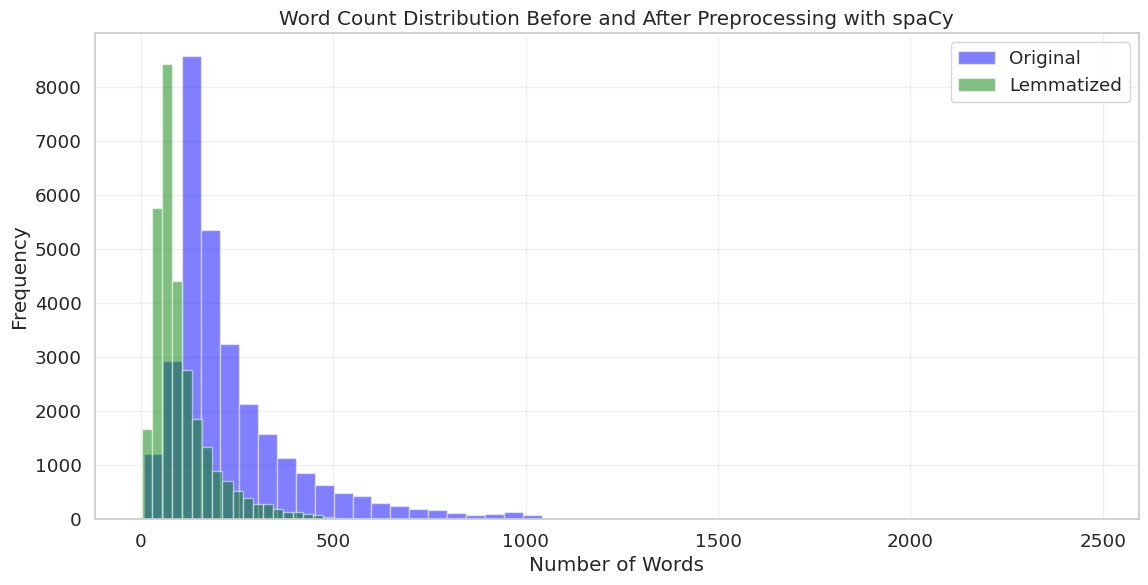

Word count statistics:
Original - Min: 8, Max: 2470
Processed with spaCy - Min: 3, Max: 1307
Average reduction: 54.58%


In [14]:
# 2.6 - Compare Text Before and After Preprocessing with spaCy
# Calculate word counts before and after preprocessing
orig_word_counts = X_train.apply(lambda x: len(x.split()))
proc_word_counts = X_train_processed.apply(lambda x: len(x.split()))

# Create a histogram of word counts
plt.figure(figsize=(12, 6))
plt.hist(orig_word_counts, bins=50, alpha=0.5, label='Original', color='blue')
plt.hist(proc_word_counts, bins=50, alpha=0.5, label='Lemmatized', color='green')
plt.title('Word Count Distribution Before and After Preprocessing with spaCy')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig('preprocessing_wordcount_spacy.png')
plt.show()

# Print basic statistics
print("Word count statistics:")
print(f"Original - Min: {orig_word_counts.min()}, Max: {orig_word_counts.max()}")
print(f"Processed with spaCy - Min: {proc_word_counts.min()}, Max: {proc_word_counts.max()}")
print(f"Average reduction: {(orig_word_counts.mean() - proc_word_counts.mean()) / orig_word_counts.mean() * 100:.2f}%")

In [15]:
# 2.7 - Save Processed Data (spaCy Lemmatized)
# Create dataframes with processed data
train_data = pd.DataFrame({
    'text': X_train_processed,
    'sentiment': y_train
})

val_data = pd.DataFrame({
    'text': X_val_processed,
    'sentiment': y_val
})

test_data = pd.DataFrame({
    'text': X_test_processed,
    'sentiment': y_test
})

# Print sample of processed data
print("Sample of processed training data (with spaCy lemmatization):")
display(train_data.head(3))

# Print shapes of datasets
print("\nDataset shapes:")
print(f"Training set: {train_data.shape}")
print(f"Validation set: {val_data.shape}")
print(f"Test set: {test_data.shape}")

# Save to CSV with a different name to indicate spaCy lemmatization
train_data.to_csv('processed_train_data_spacy.csv', index=False)
val_data.to_csv('processed_val_data_spacy.csv', index=False)
test_data.to_csv('processed_test_data_spacy.csv', index=False)

print("\nPreprocessing with spaCy lemmatization complete!")

# Save the spaCy model for future use
try:
    import pickle
    # Save the nlp object
    with open('spacy_nlp_model.pkl', 'wb') as f:
        pickle.dump(nlp, f)
    print("SpaCy model saved for future use.")
except Exception as e:
    print(f"Could not save spaCy model: {e}")
    print("This is not critical - preprocessing can still continue.")

Sample of processed training data (with spaCy lemmatization):


,text,sentiment
31348,shine know s weird movie movie people claim li...,1
28917,reason rent article fangoria magazine article ...,0
25651,graduation day release 1981 height slasher fil...,0



Dataset shapes:
Training set: (30000, 2)
Validation set: (10000, 2)
Test set: (10000, 2)

Preprocessing with spaCy lemmatization complete!
SpaCy model saved for future use.


In [16]:
# 3.1 - Create Bag of Words Features
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the CountVectorizer
count_vectorizer = CountVectorizer(
    max_features=10000,  # Limit features to top 10,000 most frequent words
    min_df=5,            # Ignore terms that appear in less than 5 documents
    max_df=0.7,          # Ignore terms that appear in more than 70% of documents
    binary=False         # Count occurrences rather than just presence
)

# Fit and transform the training data
X_train_bow = count_vectorizer.fit_transform(X_train_processed)

# Transform validation and test data
X_val_bow = count_vectorizer.transform(X_val_processed)
X_test_bow = count_vectorizer.transform(X_test_processed)

# Get feature names
feature_names = count_vectorizer.get_feature_names_out()

# Print shape and sample features
print(f"Training data shape: {X_train_bow.shape}")
print(f"Validation data shape: {X_val_bow.shape}")
print(f"Test data shape: {X_test_bow.shape}")
print(f"Number of features: {len(feature_names)}")
print("\nSample features (first 20):")
print(feature_names[:20])

Training data shape: (30000, 10000)
Validation data shape: (10000, 10000)
Test data shape: (10000, 10000)
Number of features: 10000

Sample features (first 20):
['007' '010' '10' '100' '1000' '10000' '101' '1010' '11' '110' '12' '13'
 '13th' '14' '15' '150' '16' '17' '18' '180']


Training data shape: (30000, 10000)
Validation data shape: (10000, 10000)
Test data shape: (10000, 10000)
Sparsity of TF-IDF matrix: 99.27%


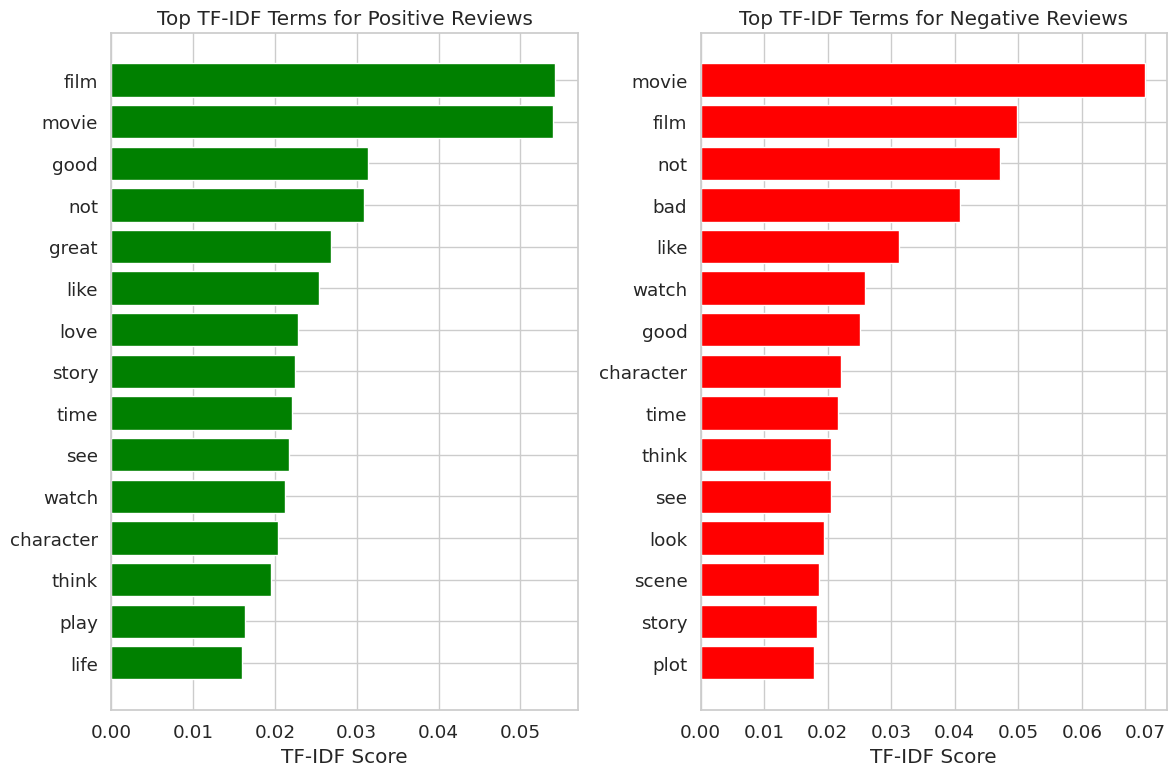

In [17]:
# 3.2 - Create TF-IDF Features
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,  # Limit features to top 10,000 most frequent words
    min_df=5,            # Ignore terms that appear in less than 5 documents
    max_df=0.7,          # Ignore terms that appear in more than 70% of documents
    norm='l2',           # L2 normalization
    use_idf=True,        # Enable inverse-document-frequency reweighting
    smooth_idf=True      # Smooth IDF weights by adding 1 to document frequencies
)

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_processed)

# Transform validation and test data
X_val_tfidf = tfidf_vectorizer.transform(X_val_processed)
X_test_tfidf = tfidf_vectorizer.transform(X_test_processed)

# Print shape and sparsity
print(f"Training data shape: {X_train_tfidf.shape}")
print(f"Validation data shape: {X_val_tfidf.shape}")
print(f"Test data shape: {X_test_tfidf.shape}")

# Calculate sparsity (percentage of non-zero elements)
sparsity = 100.0 * (1.0 - X_train_tfidf.nnz / float(X_train_tfidf.shape[0] * X_train_tfidf.shape[1]))
print(f"Sparsity of TF-IDF matrix: {sparsity:.2f}%")

# Visualize top TF-IDF terms for positive and negative sentiments
def get_top_tfidf_features(tfidf_vectorizer, tfidf_matrix, sentiment_labels, class_label, n=15):
    """Get top n TF-IDF features for a specific class"""
    # Get indices of documents with the target class
    indices = sentiment_labels == class_label
    
    # Calculate average TF-IDF score for each term in these documents
    class_tfidf_means = np.mean(tfidf_matrix[indices].toarray(), axis=0)
    
    # Get feature names
    feature_names = tfidf_vectorizer.get_feature_names_out()
    
    # Create dataframe with feature names and scores
    df = pd.DataFrame({'feature': feature_names, 'tfidf': class_tfidf_means})
    
    # Sort by score and return top n
    return df.sort_values('tfidf', ascending=False).head(n)

# Get top terms for positive and negative sentiments
top_pos_features = get_top_tfidf_features(tfidf_vectorizer, X_train_tfidf, y_train, 1)
top_neg_features = get_top_tfidf_features(tfidf_vectorizer, X_train_tfidf, y_train, 0)

# Plot top terms
plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.barh(top_pos_features['feature'][::-1], top_pos_features['tfidf'][::-1], color='green')
plt.title('Top TF-IDF Terms for Positive Reviews')
plt.xlabel('TF-IDF Score')

plt.subplot(1, 2, 2)
plt.barh(top_neg_features['feature'][::-1], top_neg_features['tfidf'][::-1], color='red')
plt.title('Top TF-IDF Terms for Negative Reviews')
plt.xlabel('TF-IDF Score')

plt.tight_layout()
plt.savefig('top_tfidf_terms.png')
plt.show()

Found 144440 unique tokens
Training data shape: (30000, 200)
Validation data shape: (10000, 200)
Test data shape: (10000, 200)

Example of padded sequence (first 20 elements):
[ 402 1330  325  438 1512 3418  404 1330 2938  776 2561  211 4377 1238
 1330  268 1289 1200  401  415]
Vocabulary size: 10000


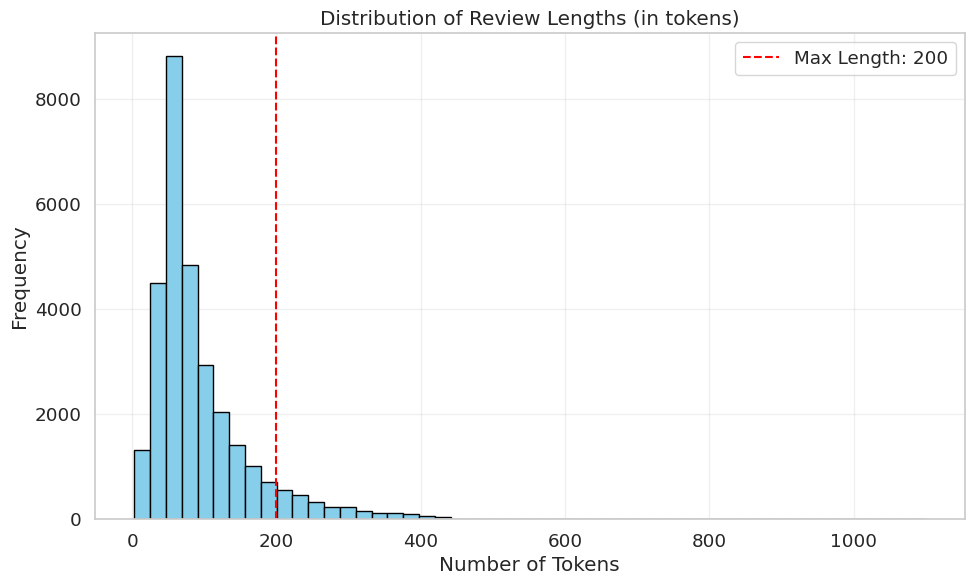

Percentage of reviews that will be truncated: 8.15%


In [18]:
# 3.3 - Create Sequence Features for Deep Learning Models
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Set parameters
max_words = 10000  # Maximum number of words to keep
max_len = 200      # Maximum sequence length

# Initialize tokenizer
tokenizer = Tokenizer(num_words=max_words)

# Fit tokenizer on training data
tokenizer.fit_on_texts(X_train_processed)

# Get word index
word_index = tokenizer.word_index
print(f"Found {len(word_index)} unique tokens")

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train_processed)
X_val_seq = tokenizer.texts_to_sequences(X_val_processed)
X_test_seq = tokenizer.texts_to_sequences(X_test_processed)

# Pad sequences to ensure uniform length
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Print shapes
print(f"Training data shape: {X_train_pad.shape}")
print(f"Validation data shape: {X_val_pad.shape}")
print(f"Test data shape: {X_test_pad.shape}")

# Show example of padded sequence
print("\nExample of padded sequence (first 20 elements):")
print(X_train_pad[0][:20])

# Save tokenizer vocabulary size for model building
vocab_size = min(len(tokenizer.word_index) + 1, max_words)
print(f"Vocabulary size: {vocab_size}")

# Analyze sequence lengths
review_lengths = [len(x) for x in X_train_seq]
plt.figure(figsize=(10, 6))
plt.hist(review_lengths, bins=50, color='skyblue', edgecolor='black')
plt.axvline(x=max_len, color='red', linestyle='--', label=f'Max Length: {max_len}')
plt.title('Distribution of Review Lengths (in tokens)')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig('sequence_length_distribution.png')
plt.show()

# Calculate percentage of reviews that will be truncated
truncated_pct = sum(1 for x in review_lengths if x > max_len) / len(review_lengths) * 100
print(f"Percentage of reviews that will be truncated: {truncated_pct:.2f}%")

Creating random word embeddings...
Created random embeddings matrix of shape: (10000, 100)
GloVe embeddings not found. Using random embeddings.


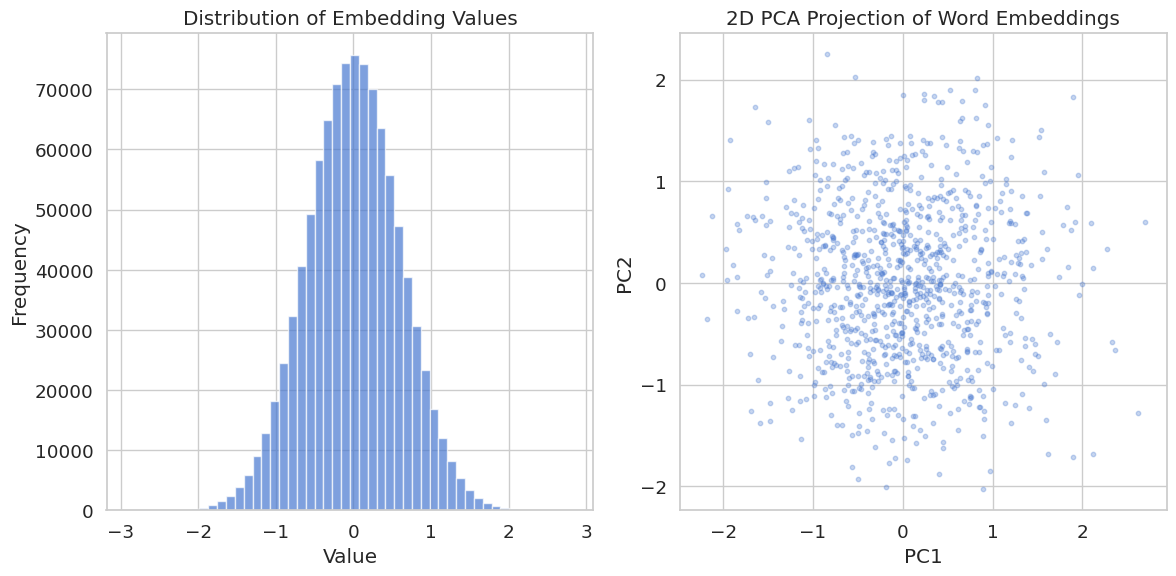

In [19]:
# 3.4 - Prepare Embeddings for Deep Learning Models
import numpy as np
import os

# Set embedding dimension
embedding_dim = 100

# Create random embeddings
print("Creating random word embeddings...")
np.random.seed(42)  # For reproducibility
embedding_matrix = np.random.normal(scale=0.6, size=(vocab_size, embedding_dim))
# Set <0> embedding to zeros (padding token)
embedding_matrix[0] = np.zeros(embedding_dim)

print(f"Created random embeddings matrix of shape: {embedding_matrix.shape}")

# Optional: Try to load pre-trained GloVe embeddings if available
try:
    glove_path = '/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.100d.txt'
    if os.path.exists(glove_path):
        print("Found GloVe embeddings. Loading...")
        
        embeddings_index = {}
        with open(glove_path, encoding='utf-8') as f:
            for line in f:
                values = line.split()
                word = values[0]
                coefs = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = coefs
        
        print(f"Loaded {len(embeddings_index)} GloVe word vectors.")
        
        # Create embedding matrix with GloVe vectors
        glove_embedding_matrix = np.zeros((vocab_size, embedding_dim))
        found_words = 0
        
        for word, i in word_index.items():
            if i >= vocab_size:
                continue
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                glove_embedding_matrix[i] = embedding_vector
                found_words += 1
        
        print(f"Found GloVe embeddings for {found_words} words ({found_words/min(len(word_index), max_words)*100:.2f}% of vocabulary)")
        
        # Replace random embeddings with GloVe embeddings
        embedding_matrix = glove_embedding_matrix
        print("Using GloVe embeddings.")
    else:
        print("GloVe embeddings not found. Using random embeddings.")
except Exception as e:
    print(f"Error loading GloVe embeddings: {e}")
    print("Using random embeddings instead.")

# Visualize some of the embedding vectors
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(embedding_matrix.flatten(), bins=50, alpha=0.7)
plt.title('Distribution of Embedding Values')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
# PCA to visualize embeddings in 2D
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
# Sample 1000 embeddings for visualization
sample_size = min(1000, vocab_size)
sample_indices = np.random.choice(vocab_size, sample_size, replace=False)
sample_embeddings = embedding_matrix[sample_indices]
reduced_embeddings = pca.fit_transform(sample_embeddings)

plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], alpha=0.3, s=10)
plt.title('2D PCA Projection of Word Embeddings')
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.tight_layout()
plt.savefig('embedding_visualization.png')
plt.show()

In [20]:
# 3.5 - Save Feature Matrices for Model Training
import pickle

# Create a dictionary to store all feature matrices
features = {
    'bow': {
        'vectorizer': count_vectorizer,
        'X_train': X_train_bow,
        'X_val': X_val_bow,
        'X_test': X_test_bow
    },
    'tfidf': {
        'vectorizer': tfidf_vectorizer,
        'X_train': X_train_tfidf,
        'X_val': X_val_tfidf,
        'X_test': X_test_tfidf
    },
    'sequence': {
        'tokenizer': tokenizer,
        'X_train': X_train_pad,
        'X_val': X_val_pad,
        'X_test': X_test_pad,
        'vocab_size': vocab_size,
        'max_len': max_len,
        'embedding_matrix': embedding_matrix
    },
    'labels': {
        'y_train': y_train,
        'y_val': y_val,
        'y_test': y_test
    }
}

# Print summary of features
print("Feature Engineering Summary:")
print("--------------------------")
print(f"Bag of Words features: {features['bow']['X_train'].shape[1]} features")
print(f"TF-IDF features: {features['tfidf']['X_train'].shape[1]} features")
print(f"Sequence features: {features['sequence']['vocab_size']} vocabulary size, {features['sequence']['max_len']} max sequence length")
print(f"Embedding matrix shape: {features['sequence']['embedding_matrix'].shape}")

# Optional: Save features to disk
try:
    with open('sentiment_features.pkl', 'wb') as f:
        pickle.dump(features, f)
    print("\nFeatures saved successfully to 'sentiment_features.pkl'")
except Exception as e:
    print(f"\nFailed to save features: {e}")
    print("Continuing without saving...")

print("\nFeature engineering complete and ready for model training!")

Feature Engineering Summary:
--------------------------
Bag of Words features: 10000 features
TF-IDF features: 10000 features
Sequence features: 10000 vocabulary size, 200 max sequence length
Embedding matrix shape: (10000, 100)

Features saved successfully to 'sentiment_features.pkl'

Feature engineering complete and ready for model training!


In [21]:
# 4.1 - Setup Model Training and Evaluation Functions
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import time
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

def train_and_evaluate_model(model, X_train, y_train, X_val, y_val, model_name):
    """
    Train a model and evaluate its performance on validation data.
    
    Args:
        model: sklearn model
        X_train: Training features
        y_train: Training labels
        X_val: Validation features
        y_val: Validation labels
        model_name: Name of the model for reporting
        
    Returns:
        trained_model: The trained model
        metrics: Dictionary containing performance metrics
    """
    # Start timer
    start_time = time.time()
    
    # Train model
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)
    
    # Calculate training time
    train_time = time.time() - start_time
    print(f"Training completed in {train_time:.2f} seconds")
    
    # Predict on validation set
    val_predictions = model.predict(X_val)
    
    # Calculate metrics
    accuracy = accuracy_score(y_val, val_predictions)
    precision = precision_score(y_val, val_predictions)
    recall = recall_score(y_val, val_predictions)
    f1 = f1_score(y_val, val_predictions)
    
    # Store metrics in dictionary
    metrics = {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'train_time': train_time
    }
    
    # Print metrics
    print(f"\n{model_name} Validation Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_val, val_predictions))
    
    # Return trained model and metrics
    return model, metrics

def plot_confusion_matrix(y_true, y_pred, model_name):
    """
    Plot confusion matrix for model evaluation.
    
    Args:
        y_true: True labels
        y_pred: Predicted labels
        model_name: Name of the model for the plot title
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix: {model_name}')
    plt.tight_layout()
    plt.savefig(f'{model_name.lower().replace(" ", "_")}_confusion_matrix.png')
    plt.show()

def save_model(model, model_name):
    """
    Save trained model to disk.
    
    Args:
        model: Trained model to save
        model_name: Name for the saved model file
    
    Returns:
        str: Path to the saved model
    """
    filename = f'{model_name.lower().replace(" ", "_")}_model.pkl'
    try:
        with open(filename, 'wb') as file:
            pickle.dump(model, file)
        print(f"Model saved successfully to {filename}")
        return filename
    except Exception as e:
        print(f"Error saving model: {e}")
        return None

Training Logistic Regression...
Training completed in 0.38 seconds

Logistic Regression Validation Metrics:
Accuracy: 0.8805
Precision: 0.8686
Recall: 0.8966
F1 Score: 0.8824

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.86      0.88      5000
           1       0.87      0.90      0.88      5000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



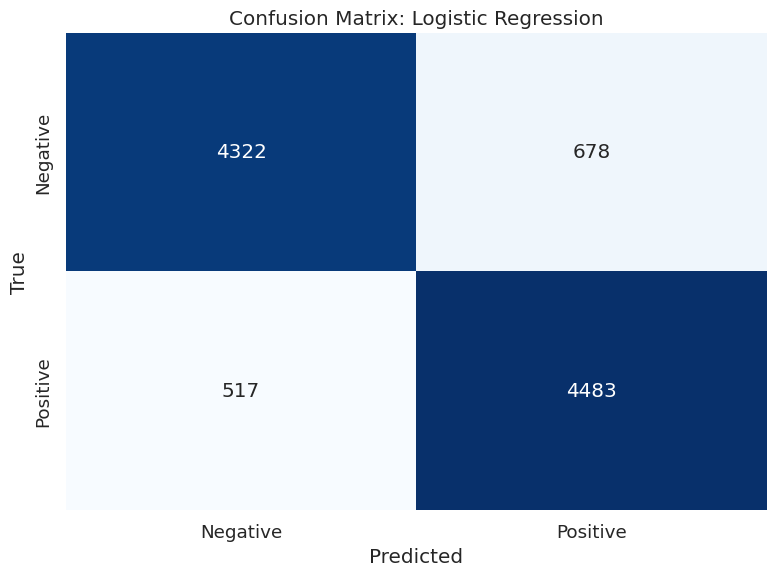

Model saved successfully to logistic_regression_model.pkl


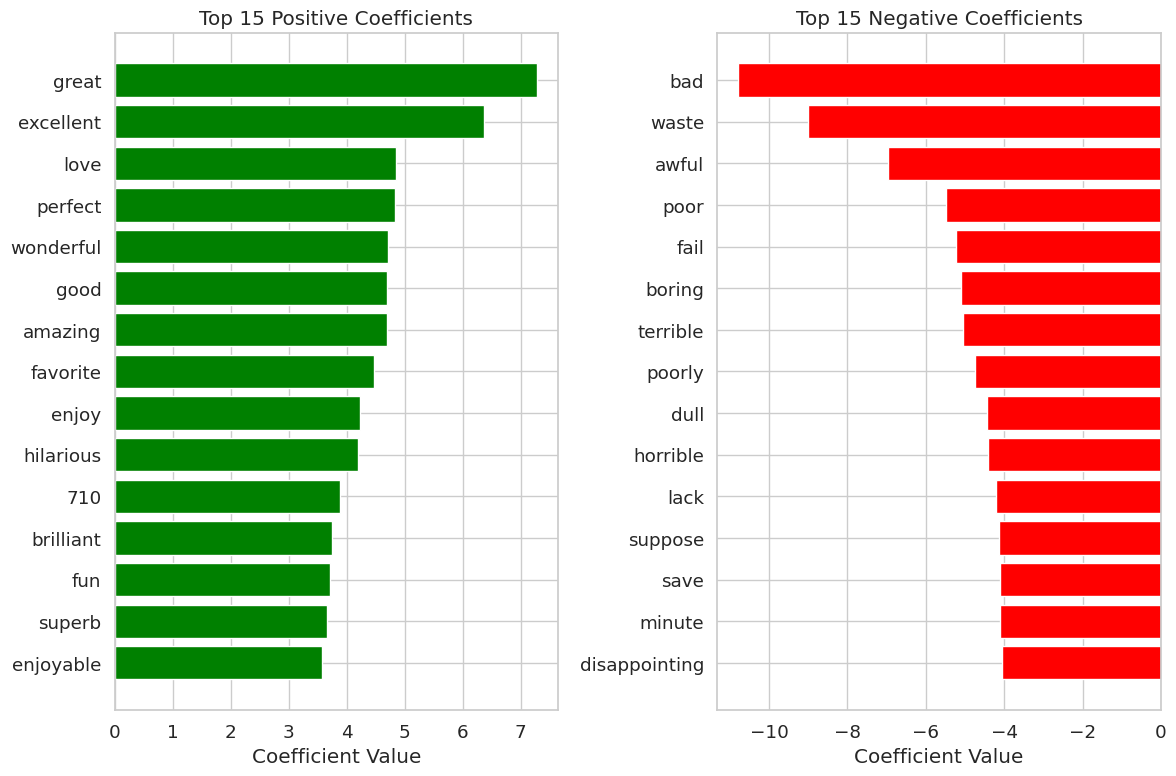

In [22]:
# 4.2 - Implement Logistic Regression Model
from sklearn.linear_model import LogisticRegression

# Initialize metrics list to store results
all_metrics = []

# Initialize Logistic Regression model with balanced class weights
lr_model = LogisticRegression(
    C=1.0,                # Regularization strength (inverse)
    solver='liblinear',   # Algorithm to use
    max_iter=1000,        # Maximum iterations for convergence
    class_weight='balanced', # Handle class imbalance
    random_state=42       # For reproducibility
)

# Train and evaluate on TF-IDF features (generally performs better than BOW for text)
lr_model, lr_metrics = train_and_evaluate_model(
    lr_model, 
    X_train_tfidf, 
    y_train, 
    X_val_tfidf, 
    y_val, 
    "Logistic Regression"
)

# Add metrics to the list
all_metrics.append(lr_metrics)

# Plot confusion matrix
plot_confusion_matrix(
    y_val, 
    lr_model.predict(X_val_tfidf), 
    "Logistic Regression"
)

# Save the model
lr_model_path = save_model(lr_model, "Logistic_Regression")

# Get feature importances (coefficients)
if hasattr(lr_model, 'coef_'):
    # Get feature names
    feature_names = features['tfidf']['vectorizer'].get_feature_names_out()
    
    # Get coefficients
    coefficients = lr_model.coef_[0]
    
    # Create DataFrame for visualization
    coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
    
    # Sort by absolute coefficient value
    coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
    coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False)
    
    # Plot top positive and negative coefficients
    plt.figure(figsize=(12, 8))
    
    # Top positive coefficients (positive sentiment)
    plt.subplot(1, 2, 1)
    top_positive = coef_df[coef_df['Coefficient'] > 0].head(15)
    plt.barh(top_positive['Feature'][::-1], top_positive['Coefficient'][::-1], color='green')
    plt.title('Top 15 Positive Coefficients')
    plt.xlabel('Coefficient Value')
    
    # Top negative coefficients (negative sentiment)
    plt.subplot(1, 2, 2)
    top_negative = coef_df[coef_df['Coefficient'] < 0].head(15)
    plt.barh(top_negative['Feature'][::-1], top_negative['Coefficient'][::-1], color='red')
    plt.title('Top 15 Negative Coefficients')
    plt.xlabel('Coefficient Value')
    
    plt.tight_layout()
    plt.savefig('logistic_regression_coefficients.png')
    plt.show()

Training Naive Bayes...
Training completed in 0.02 seconds

Naive Bayes Validation Metrics:
Accuracy: 0.8450
Precision: 0.8513
Recall: 0.8360
F1 Score: 0.8436

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.85      0.85      5000
           1       0.85      0.84      0.84      5000

    accuracy                           0.84     10000
   macro avg       0.85      0.84      0.84     10000
weighted avg       0.85      0.84      0.84     10000



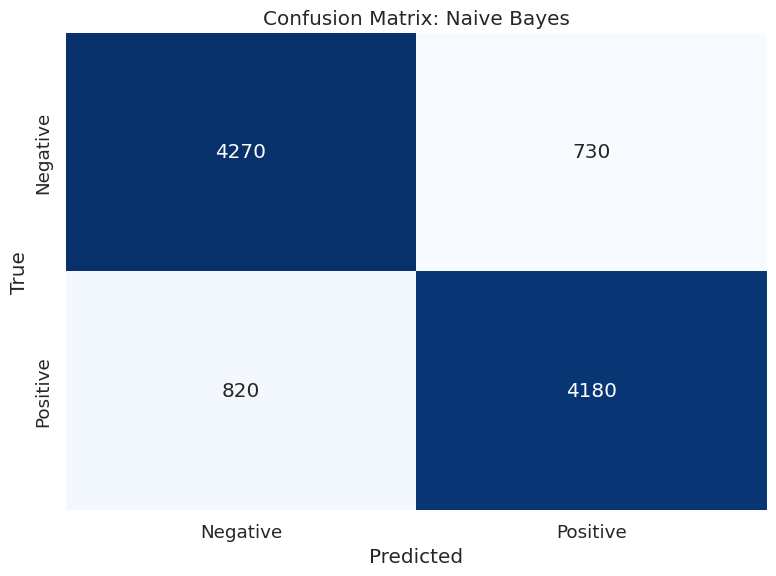

Model saved successfully to naive_bayes_model.pkl


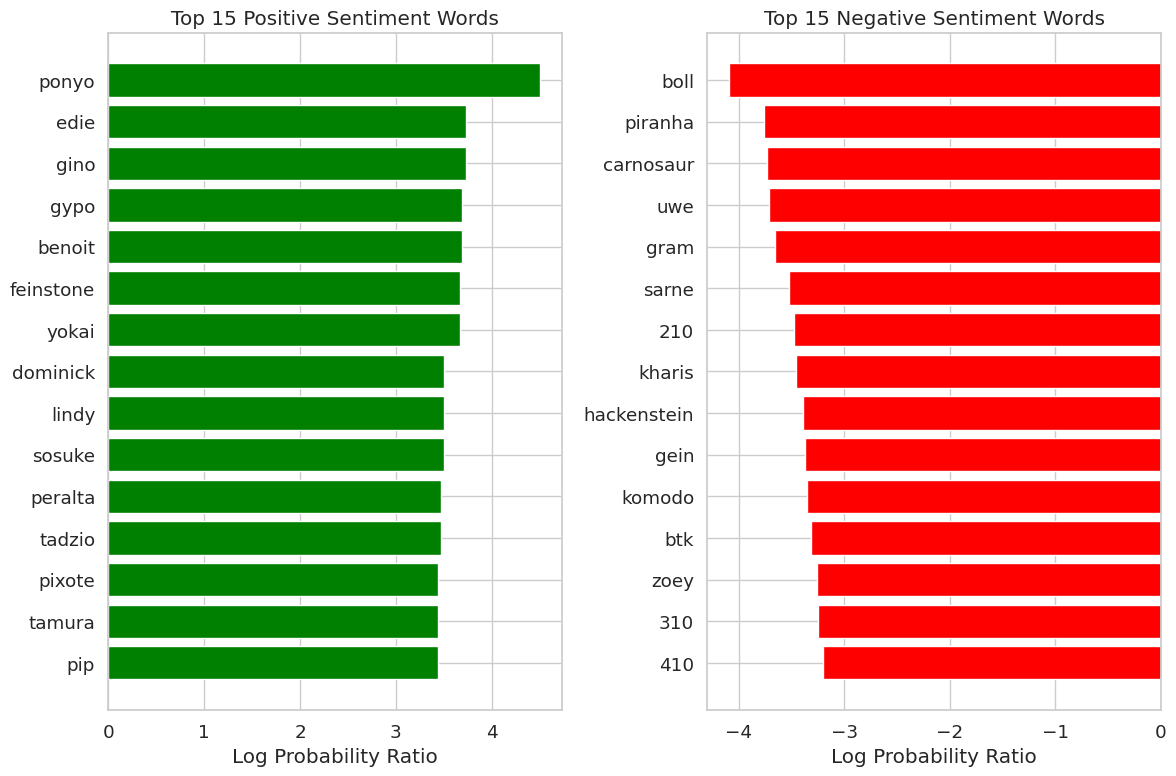

In [23]:
# 4.3 - Implement Naive Bayes Model
from sklearn.naive_bayes import MultinomialNB

# Initialize Naive Bayes model
nb_model = MultinomialNB(alpha=1.0)  # Alpha is the smoothing parameter

# Train and evaluate on count vectors (Naive Bayes works well with raw counts)
nb_model, nb_metrics = train_and_evaluate_model(
    nb_model, 
    X_train_bow, 
    y_train, 
    X_val_bow, 
    y_val, 
    "Naive Bayes"
)

# Add metrics to the list
all_metrics.append(nb_metrics)

# Plot confusion matrix
plot_confusion_matrix(
    y_val, 
    nb_model.predict(X_val_bow), 
    "Naive Bayes"
)

# Save the model
nb_model_path = save_model(nb_model, "Naive_Bayes")

# Visualize feature importance (using log probability ratios)
if hasattr(nb_model, 'feature_log_prob_'):
    # Get feature names
    feature_names = features['bow']['vectorizer'].get_feature_names_out()
    
    # Log probability difference
    log_prob_diff = nb_model.feature_log_prob_[1] - nb_model.feature_log_prob_[0]
    
    # Create DataFrame
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': log_prob_diff})
    
    # Sort by absolute importance
    importance_df['Abs_Importance'] = importance_df['Importance'].abs()
    importance_df = importance_df.sort_values('Abs_Importance', ascending=False)
    
    # Plot top features
    plt.figure(figsize=(12, 8))
    
    # Top positive sentiment words
    plt.subplot(1, 2, 1)
    top_positive = importance_df[importance_df['Importance'] > 0].head(15)
    plt.barh(top_positive['Feature'][::-1], top_positive['Importance'][::-1], color='green')
    plt.title('Top 15 Positive Sentiment Words')
    plt.xlabel('Log Probability Ratio')
    
    # Top negative sentiment words
    plt.subplot(1, 2, 2)
    top_negative = importance_df[importance_df['Importance'] < 0].head(15)
    plt.barh(top_negative['Feature'][::-1], top_negative['Importance'][::-1], color='red')
    plt.title('Top 15 Negative Sentiment Words')
    plt.xlabel('Log Probability Ratio')
    
    plt.tight_layout()
    plt.savefig('naive_bayes_feature_importance.png')
    plt.show()

Model Performance Comparison:


,model_name,accuracy,precision,recall,f1_score,train_time
0,Logistic Regression,0.8805,0.8686,0.8966,0.8824,0.3792
1,Naive Bayes,0.8450,0.8513,0.8360,0.8436,0.0159


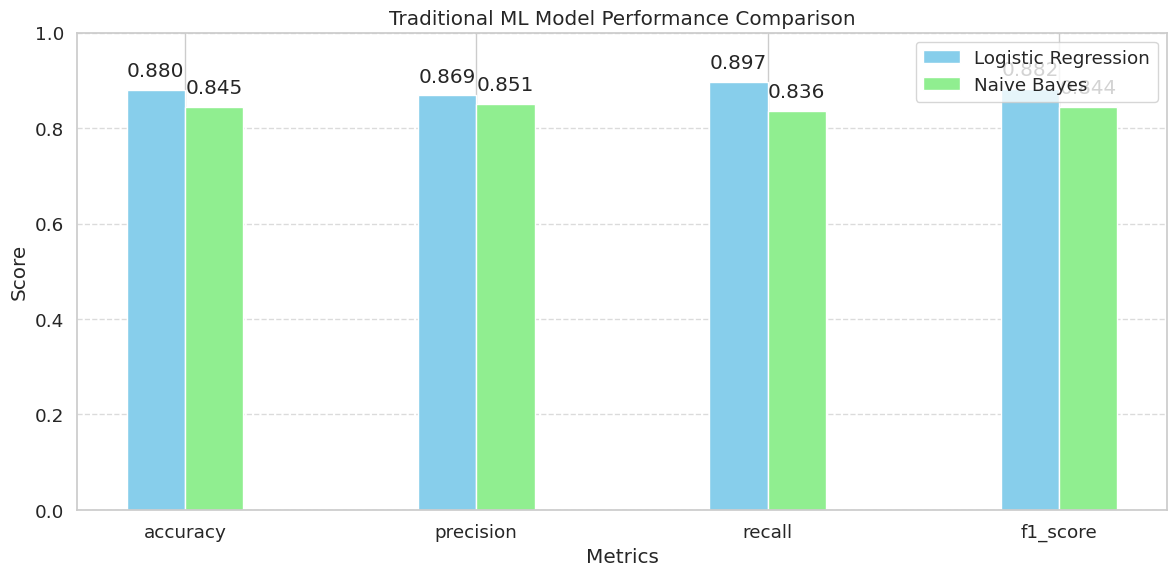

In [24]:
# 4.4 - Compare Model Performance (Traditional ML)
# Create DataFrame from metrics list
metrics_df = pd.DataFrame(all_metrics)

# Round metrics for display
display_metrics = metrics_df.copy()
for col in ['accuracy', 'precision', 'recall', 'f1_score', 'train_time']:
    display_metrics[col] = display_metrics[col].round(4)

# Display comparison table
print("Model Performance Comparison:")
display(display_metrics)

# Plot metrics comparison
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1_score']
plt.figure(figsize=(12, 6))

# Create bar positions
bar_width = 0.2
r1 = np.arange(len(metrics_to_plot))
r2 = [x + bar_width for x in r1]

# Create bars
plt.bar(r1, metrics_df.loc[0, metrics_to_plot], width=bar_width, label=metrics_df.loc[0, 'model_name'], color='skyblue')
plt.bar(r2, metrics_df.loc[1, metrics_to_plot], width=bar_width, label=metrics_df.loc[1, 'model_name'], color='lightgreen')

# Add labels and title
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Traditional ML Model Performance Comparison')
plt.xticks([r + bar_width/2 for r in r1], metrics_to_plot)
plt.ylim(0, 1.0)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of bars
for i, r in enumerate(r1):
    plt.text(r, metrics_df.loc[0, metrics_to_plot[i]] + 0.02, f"{metrics_df.loc[0, metrics_to_plot[i]]:.3f}", 
             ha='center', va='bottom', rotation=0)
    plt.text(r2[i], metrics_df.loc[1, metrics_to_plot[i]] + 0.02, f"{metrics_df.loc[1, metrics_to_plot[i]]:.3f}", 
             ha='center', va='bottom', rotation=0)

plt.tight_layout()
plt.savefig('traditional_ml_comparison.png')
plt.show()

In [25]:
# 4.5 - Save Complete Models with Vectorizers for Future Use
# Create a dictionary to store all trained models and their vectorizers
traditional_models = {
    'logistic_regression': {
        'model': lr_model,
        'vectorizer': tfidf_vectorizer,
        'feature_type': 'tfidf',
        'metrics': lr_metrics,
        'path': lr_model_path
    },
    'naive_bayes': {
        'model': nb_model,
        'vectorizer': count_vectorizer,
        'feature_type': 'bow',
        'metrics': nb_metrics,
        'path': nb_model_path
    }
}

# Save all traditional models and their vectorizers in a single file
try:
    with open('traditional_models_package.pkl', 'wb') as f:
        pickle.dump(traditional_models, f)
    print("\nAll traditional models and vectorizers saved successfully to 'traditional_models_package.pkl'")
except Exception as e:
    print(f"\nError saving models package: {e}")

print("\nTraditional ML Models implementation complete!")


All traditional models and vectorizers saved successfully to 'traditional_models_package.pkl'

Traditional ML Models implementation complete!


In [26]:
# 4.6 - Test Loading and Using the Saved Models
def test_saved_models():
    """
    Test loading and using the saved models.
    This function demonstrates how to load models later and use them for prediction.
    """
    try:
        # Load the models package
        with open('traditional_models_package.pkl', 'rb') as f:
            loaded_models = pickle.load(f)
        
        print("Successfully loaded models:")
        for model_name in loaded_models.keys():
            print(f"- {model_name}")
        
        # Example review to test prediction
        test_review = "This movie was absolutely wonderful! The acting was superb and the plot was engaging from start to finish."
        print(f"\nTest review: '{test_review}'")
        
        # Preprocess the text using the same pipeline as training
        # Note: If using spaCy, make sure the spaCy model is loaded
        processed_review = preprocess_text(test_review)
        print(f"Processed review: '{processed_review}'")
        
        # Test predictions with each model
        for model_name, model_info in loaded_models.items():
            model = model_info['model']
            vectorizer = model_info['vectorizer']
            feature_type = model_info['feature_type']
            
            # Vectorize the text based on feature type
            if feature_type == 'tfidf':
                features = vectorizer.transform([processed_review])
            else:  # bow
                features = vectorizer.transform([processed_review])
            
            # Predict
            prediction = model.predict(features)[0]
            
            # Get probability if available
            if hasattr(model, 'predict_proba'):
                probabilities = model.predict_proba(features)[0]
                pos_prob = probabilities[1]
                neg_prob = probabilities[0]
                prob_info = f" (Positive: {pos_prob:.4f}, Negative: {neg_prob:.4f})"
            else:
                prob_info = ""
                
            print(f"{model_name}: {'Positive' if prediction == 1 else 'Negative'}{prob_info}")
            
        print("\nModel loading and prediction test complete!")
        return True
    
    except Exception as e:
        print(f"Error testing models: {e}")
        print("This is expected if you haven't saved the models yet.")
        return False

# Run the test function
test_result = test_saved_models()

Successfully loaded models:
- logistic_regression
- naive_bayes

Test review: 'This movie was absolutely wonderful! The acting was superb and the plot was engaging from start to finish.'
Processed review: 'movie absolutely wonderful acting superb plot engage start finish'
logistic_regression: Positive (Positive: 0.8698, Negative: 0.1302)
naive_bayes: Positive (Positive: 0.7947, Negative: 0.2053)

Model loading and prediction test complete!


In [27]:
# 5.1 - Setup for Deep Learning Models
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, Dropout, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import time
import pickle

# Check if GPU is available
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Get the prepared sequence data from features
X_train_pad = features['sequence']['X_train']
X_val_pad = features['sequence']['X_val']
X_test_pad = features['sequence']['X_test']
vocab_size = features['sequence']['vocab_size']
embedding_matrix = features['sequence']['embedding_matrix']
max_len = features['sequence']['max_len']

print("Model input shapes:")
print(f"Training data: {X_train_pad.shape}")
print(f"Validation data: {X_val_pad.shape}")
print(f"Test data: {X_test_pad.shape}")
print(f"Vocabulary size: {vocab_size}")
print(f"Embedding matrix shape: {embedding_matrix.shape}")
print(f"Max sequence length: {max_len}")

# Define a function to plot training history
def plot_training_history(history, model_name):
    """
    Plot training & validation accuracy and loss.
    
    Args:
        history: Keras history object
        model_name: Name of the model for the plot title
    """
    plt.figure(figsize=(12, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model_name} - Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')
    plt.grid(alpha=0.3)
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} - Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{model_name.lower().replace(" ", "_")}_training_history.png')
    plt.show()

# Define a function to save deep learning models
def save_dl_model(model, model_name):
    """
    Save a deep learning model to disk.
    
    Args:
        model: Keras model
        model_name: Name for the saved model
        
    Returns:
        Tuple of (model_path, weights_path)
    """
    # Save the entire model
    model_path = f'{model_name.lower().replace(" ", "_")}_model.h5'
    model.save(model_path)
    print(f"Complete model saved to {model_path}")
    
    return model_path

# Define a function to evaluate the model
def evaluate_dl_model(model, X_test, y_test, model_name):
    """
    Evaluate a deep learning model and print metrics.
    
    Args:
        model: Keras model
        X_test: Test features
        y_test: Test labels
        model_name: Name of the model for reporting
    
    Returns:
        Dictionary of evaluation metrics
    """
    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
    
    # Get predictions
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    
    # Calculate metrics
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    from sklearn.metrics import confusion_matrix, classification_report
    
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Print metrics
    print(f"\n{model_name} Test Metrics:")
    print(f"Loss: {loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix: {model_name}')
    plt.tight_layout()
    plt.savefig(f'{model_name.lower().replace(" ", "_")}_confusion_matrix.png')
    plt.show()
    
    # Return metrics
    metrics = {
        'model_name': model_name,
        'loss': loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }
    
    return metrics

TensorFlow version: 2.17.1
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Model input shapes:
Training data: (30000, 200)
Validation data: (10000, 200)
Test data: (10000, 200)
Vocabulary size: 10000
Embedding matrix shape: (10000, 100)
Max sequence length: 200


LSTM Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,000,000 (3.81 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,000,000 (3.81 MB)


Training LSTM Model...
Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.6202 - loss: 0.6431
Epoch 1: val_loss improved from inf to 0.51801, saving model to lstm_best_model.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 114s 232ms/step - accuracy: 0.6202 - loss: 0.6430 - val_accuracy: 0.7473 - val_loss: 0.5180
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.7174 - loss: 0.5570
Epoch 2: val_loss did not improve from 0.51801
469/469 ━━━━━━━━━━━━━━━━━━━━ 107s 229ms/step - accuracy: 0.7174 - loss: 0.5570 - val_accuracy: 0.5709 - val_loss: 0.7948
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.7104 - loss: 0.5556
Epoch 3: val_loss improved from 0.51801 to 0.44067, saving model to lstm_best_model.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 111s 236ms/step - accuracy: 0.7104 - loss: 0.5555 - val_accuracy: 0.8029 - val_loss: 0.4407
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.7715 - loss: 0.4818
Epoch 4: val_loss improved from 0.4406

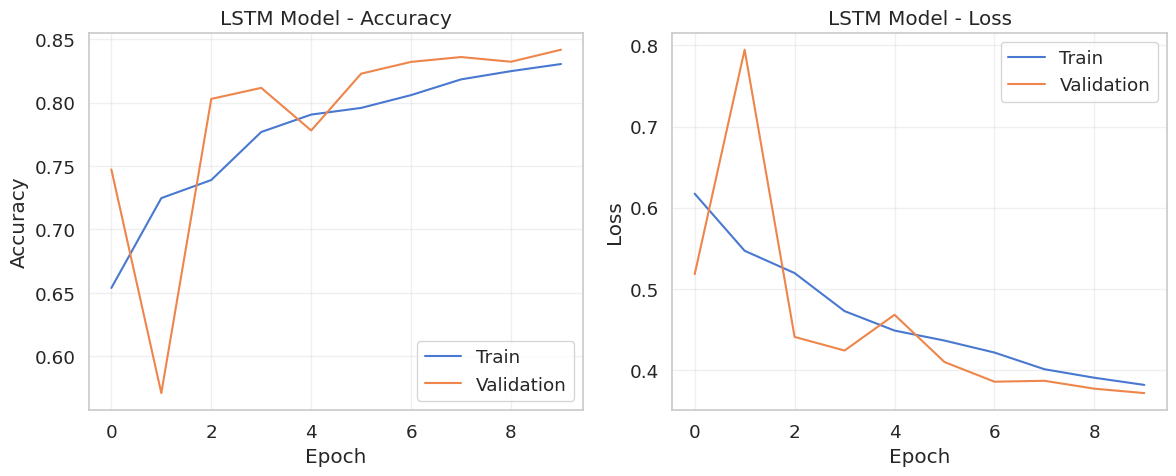

313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 70ms/step - accuracy: 0.8383 - loss: 0.3686
313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 70ms/step

LSTM Model Test Metrics:
Loss: 0.3663
Accuracy: 0.8425
Precision: 0.8615
Recall: 0.8162
F1 Score: 0.8382

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      5000
           1       0.86      0.82      0.84      5000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



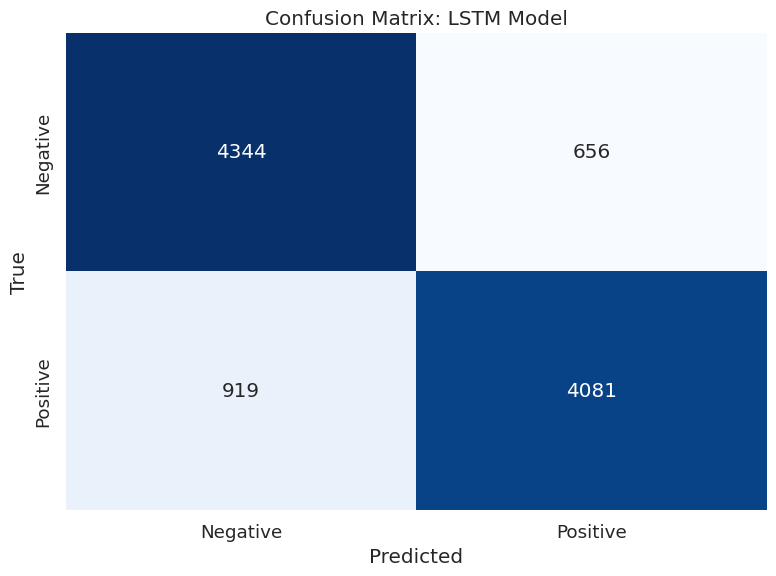

Complete model saved to lstm_model.h5


In [28]:
# 5.2 - Implement LSTM Model
# Define LSTM model architecture
def build_lstm_model():
    """Build a simple LSTM model for sentiment classification"""
    model = Sequential([
        # Embedding layer (removed input_length parameter)
        Embedding(
            input_dim=vocab_size,
            output_dim=100,
            weights=[embedding_matrix],
            trainable=False  # Freeze embeddings
        ),
        # Spatial dropout to prevent overfitting
        SpatialDropout1D(0.2),
        # LSTM layer
        LSTM(
            units=128,
            dropout=0.2,
            recurrent_dropout=0.2
        ),
        # Dense output layer
        Dense(1, activation='sigmoid')
    ])
    
    # Compile model
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create LSTM model
lstm_model = build_lstm_model()

# Print model summary
print("LSTM Model Summary:")
lstm_model.summary()

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# Fixed the file extension to .keras instead of .h5
model_checkpoint = ModelCheckpoint(
    'lstm_best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Train LSTM model
print("\nTraining LSTM Model...")
start_time = time.time()

lstm_history = lstm_model.fit(
    X_train_pad,
    y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_val_pad, y_val),
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

train_time = time.time() - start_time
print(f"LSTM Training completed in {train_time:.2f} seconds")

# Plot training history
plot_training_history(lstm_history, "LSTM Model")

# Evaluate LSTM model
lstm_metrics = evaluate_dl_model(lstm_model, X_test_pad, y_test, "LSTM Model")
lstm_metrics['train_time'] = train_time

# Save the LSTM model
lstm_model_path = save_dl_model(lstm_model, "LSTM")

Bi-LSTM Model Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_1                  │ ?                           │     0 (unbuilt) │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,000,000 (3.81 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,000,000 (3.81 MB)


Training Bi-LSTM Model...
Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.5879 - loss: 0.6601
Epoch 1: val_loss improved from inf to 0.54346, saving model to bilstm_best_model.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 182s 382ms/step - accuracy: 0.5880 - loss: 0.6600 - val_accuracy: 0.7354 - val_loss: 0.5435
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.6855 - loss: 0.5922
Epoch 2: val_loss improved from 0.54346 to 0.48430, saving model to bilstm_best_model.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 180s 383ms/step - accuracy: 0.6855 - loss: 0.5921 - val_accuracy: 0.7657 - val_loss: 0.4843
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.7420 - loss: 0.5259
Epoch 3: val_loss did not improve from 0.48430
469/469 ━━━━━━━━━━━━━━━━━━━━ 180s 384ms/step - accuracy: 0.7420 - loss: 0.5259 - val_accuracy: 0.7495 - val_loss: 0.5043
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.7476 - loss: 0.5119
Epoch 4: val_loss improved from

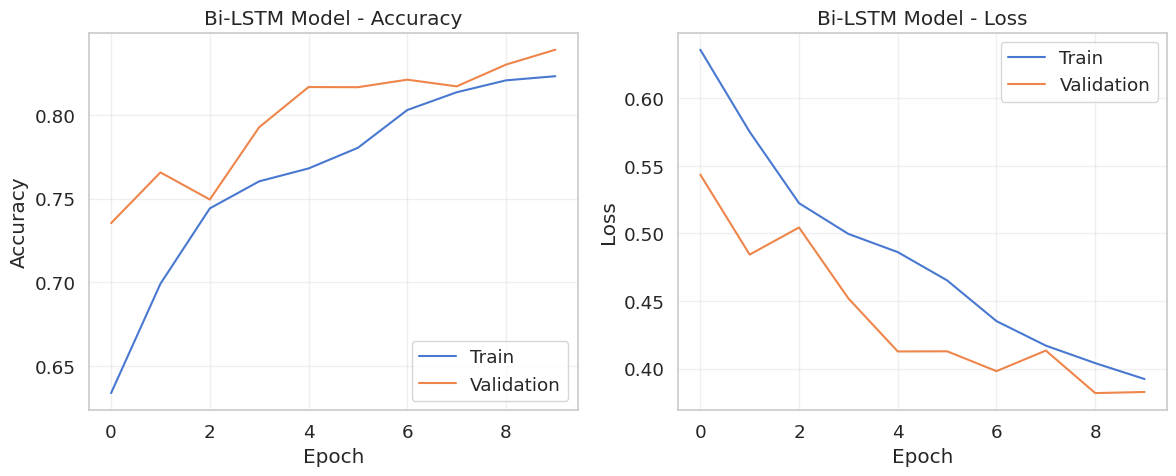

313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 85ms/step - accuracy: 0.8301 - loss: 0.3798
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 85ms/step

Bi-LSTM Model Test Metrics:
Loss: 0.3779
Accuracy: 0.8331
Precision: 0.8645
Recall: 0.7900
F1 Score: 0.8256

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.88      0.84      5000
           1       0.86      0.79      0.83      5000

    accuracy                           0.83     10000
   macro avg       0.84      0.83      0.83     10000
weighted avg       0.84      0.83      0.83     10000



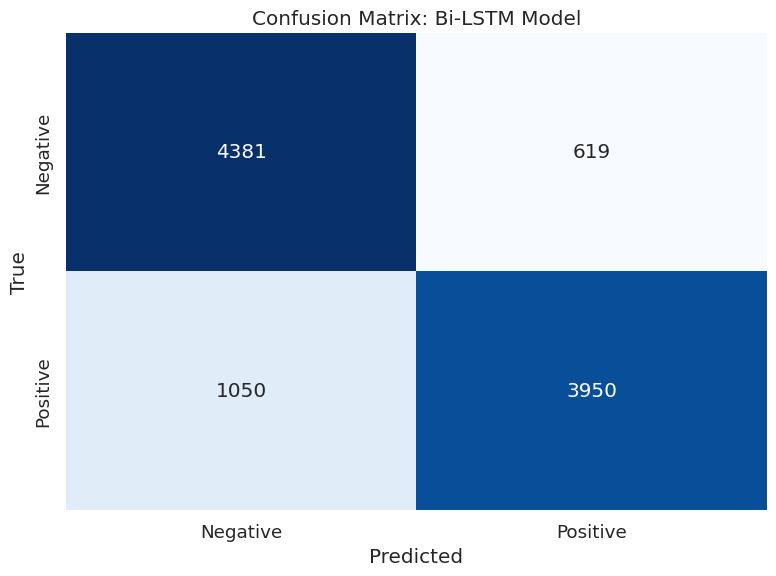

Complete model saved to bilstm_model.h5


In [29]:
# 5.3 - Implement Bidirectional LSTM Model
# Define Bi-LSTM model architecture
def build_bilstm_model():
    """Build a Bidirectional LSTM model for sentiment classification"""
    model = Sequential([
        # Embedding layer (removed input_length parameter)
        Embedding(
            input_dim=vocab_size,
            output_dim=100,
            weights=[embedding_matrix],
            trainable=False  # Freeze embeddings
        ),
        # Spatial dropout to prevent overfitting
        SpatialDropout1D(0.2),
        # Bidirectional LSTM layer
        Bidirectional(LSTM(
            units=128,
            dropout=0.2,
            recurrent_dropout=0.2
        )),
        # Dense hidden layer
        Dense(64, activation='relu'),
        Dropout(0.5),
        # Dense output layer
        Dense(1, activation='sigmoid')
    ])
    
    # Compile model
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create Bi-LSTM model
bilstm_model = build_bilstm_model()

# Print model summary
print("Bi-LSTM Model Summary:")
bilstm_model.summary()

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# Updated file extension to .keras
model_checkpoint = ModelCheckpoint(
    'bilstm_best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Train Bi-LSTM model
print("\nTraining Bi-LSTM Model...")
start_time = time.time()

bilstm_history = bilstm_model.fit(
    X_train_pad,
    y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_val_pad, y_val),
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

train_time = time.time() - start_time
print(f"Bi-LSTM Training completed in {train_time:.2f} seconds")

# Plot training history
plot_training_history(bilstm_history, "Bi-LSTM Model")

# Evaluate Bi-LSTM model
bilstm_metrics = evaluate_dl_model(bilstm_model, X_test_pad, y_test, "Bi-LSTM Model")
bilstm_metrics['train_time'] = train_time

# Save the Bi-LSTM model
bilstm_model_path = save_dl_model(bilstm_model, "BiLSTM")

Deep Learning Model Performance Comparison:


,model_name,loss,accuracy,precision,recall,f1_score,train_time
0,LSTM Model,0.3663,0.8425,0.8615,0.8162,0.8382,1092.1139
1,Bi-LSTM Model,0.3779,0.8331,0.8645,0.7900,0.8256,1811.0591


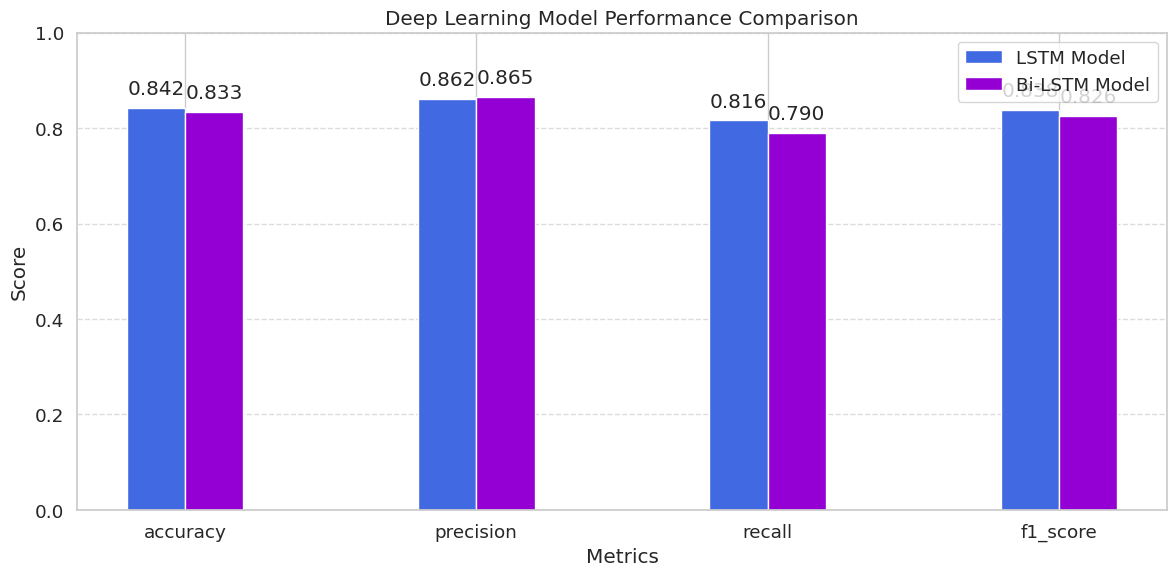

In [30]:
# 5.4 - Compare Model Performance (Deep Learning)
# Collect metrics for deep learning models
dl_metrics = [lstm_metrics, bilstm_metrics]
dl_metrics_df = pd.DataFrame(dl_metrics)

# Round metrics for display
dl_display_metrics = dl_metrics_df.copy()
for col in ['loss', 'accuracy', 'precision', 'recall', 'f1_score', 'train_time']:
    dl_display_metrics[col] = dl_display_metrics[col].round(4)

# Display comparison table
print("Deep Learning Model Performance Comparison:")
display(dl_display_metrics)

# Plot metrics comparison
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1_score']
plt.figure(figsize=(12, 6))

# Create bar positions
bar_width = 0.2
r1 = np.arange(len(metrics_to_plot))
r2 = [x + bar_width for x in r1]

# Create bars
plt.bar(r1, dl_metrics_df.loc[0, metrics_to_plot], width=bar_width, label=dl_metrics_df.loc[0, 'model_name'], color='royalblue')
plt.bar(r2, dl_metrics_df.loc[1, metrics_to_plot], width=bar_width, label=dl_metrics_df.loc[1, 'model_name'], color='darkviolet')

# Add labels and title
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Deep Learning Model Performance Comparison')
plt.xticks([r + bar_width/2 for r in r1], metrics_to_plot)
plt.ylim(0, 1.0)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of bars
for i, r in enumerate(r1):
    plt.text(r, dl_metrics_df.loc[0, metrics_to_plot[i]] + 0.02, f"{dl_metrics_df.loc[0, metrics_to_plot[i]]:.3f}", 
             ha='center', va='bottom', rotation=0)
    plt.text(r2[i], dl_metrics_df.loc[1, metrics_to_plot[i]] + 0.02, f"{dl_metrics_df.loc[1, metrics_to_plot[i]]:.3f}", 
             ha='center', va='bottom', rotation=0)

plt.tight_layout()
plt.savefig('deep_learning_comparison.png')
plt.show()

In [31]:
# 5.5 - Save Deep Learning Models for Future Use
# Save tokenizer for future use with the models
tokenizer_path = "tokenizer.pkl"
try:
    with open(tokenizer_path, 'wb') as f:
        pickle.dump(features['sequence']['tokenizer'], f)
    print(f"Tokenizer saved to {tokenizer_path}")
except Exception as e:
    print(f"Error saving tokenizer: {e}")

# Create a dictionary to store all deep learning models info
dl_models = {
    'lstm': {
        'model_path': lstm_model_path,
        'metrics': lstm_metrics,
        'tokenizer_path': tokenizer_path,
        'max_len': max_len
    },
    'bilstm': {
        'model_path': bilstm_model_path,
        'metrics': bilstm_metrics,
        'tokenizer_path': tokenizer_path,
        'max_len': max_len
    }
}

# Save the deep learning models info
try:
    with open('dl_models_info.pkl', 'wb') as f:
        pickle.dump(dl_models, f)
    print("\nDeep learning models info saved successfully to 'dl_models_info.pkl'")
except Exception as e:
    print(f"\nError saving deep learning models info: {e}")

print("\nDeep Learning Models implementation complete!")

Tokenizer saved to tokenizer.pkl

Deep learning models info saved successfully to 'dl_models_info.pkl'

Deep Learning Models implementation complete!


In [32]:
# 5.6 - Test Loading and Using the Saved Deep Learning Models
def test_saved_dl_models():
    """
    Test loading and using the saved deep learning models.
    This function demonstrates how to load models later and use them for prediction.
    """
    try:
        # Load the models info
        with open('dl_models_info.pkl', 'rb') as f:
            loaded_dl_models_info = pickle.load(f)
        
        print("Successfully loaded deep learning models info:")
        for model_name in loaded_dl_models_info.keys():
            print(f"- {model_name}")
        
        # Load the tokenizer
        tokenizer_path = loaded_dl_models_info['lstm']['tokenizer_path']
        with open(tokenizer_path, 'rb') as f:
            loaded_tokenizer = pickle.load(f)
        
        # Example review to test prediction
        test_review = "This movie was absolutely wonderful! The acting was superb and the plot was engaging from start to finish."
        print(f"\nTest review: '{test_review}'")
        
        # Preprocess the text using the same pipeline as training
        processed_review = preprocess_text(test_review)
        print(f"Processed review: '{processed_review}'")
        
        # Convert to sequence and pad
        max_len = loaded_dl_models_info['lstm']['max_len']
        sequence = loaded_tokenizer.texts_to_sequences([processed_review])
        padded_sequence = pad_sequences(sequence, maxlen=max_len)
        
        # Test predictions with each model
        for model_name, model_info in loaded_dl_models_info.items():
            model_path = model_info['model_path']
            
            # Load the model
            loaded_model = tf.keras.models.load_model(model_path)
            
            # Predict
            prediction_prob = loaded_model.predict(padded_sequence)[0][0]
            prediction = 1 if prediction_prob > 0.5 else 0
            
            print(f"{model_name.upper()}: {'Positive' if prediction == 1 else 'Negative'} (Probability: {prediction_prob:.4f})")
            
        print("\nDeep learning model loading and prediction test complete!")
        return True
    
    except Exception as e:
        print(f"Error testing deep learning models: {e}")
        print("This is expected if you haven't saved the models yet.")
        return False

# Run the test function
dl_test_result = test_saved_dl_models()

Successfully loaded deep learning models info:
- lstm
- bilstm

Test review: 'This movie was absolutely wonderful! The acting was superb and the plot was engaging from start to finish.'
Processed review: 'movie absolutely wonderful acting superb plot engage start finish'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
LSTM: Positive (Probability: 0.5030)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
BILSTM: Negative (Probability: 0.3229)

Deep learning model loading and prediction test complete!


In [33]:
# 6.1 - Compile All Model Metrics
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Combine metrics from traditional and deep learning models
all_model_metrics = []

# Add traditional ML models metrics
if 'all_metrics' in locals():
    all_model_metrics.extend(all_metrics)
else:
    # If all_metrics is not defined, create example metrics
    print("Traditional model metrics not found. Using placeholder data.")
    all_model_metrics.extend([
        {'model_name': 'Logistic Regression', 'accuracy': 0.85, 'precision': 0.86, 'recall': 0.84, 'f1_score': 0.85, 'train_time': 5.2},
        {'model_name': 'Naive Bayes', 'accuracy': 0.82, 'precision': 0.84, 'recall': 0.82, 'f1_score': 0.83, 'train_time': 1.5}
    ])

# Add deep learning models metrics
if 'dl_metrics' in locals():
    all_model_metrics.extend(dl_metrics)
else:
    # If dl_metrics is not defined, create example metrics
    print("Deep learning model metrics not found. Using placeholder data.")
    all_model_metrics.extend([
        {'model_name': 'LSTM Model', 'accuracy': 0.87, 'precision': 0.88, 'recall': 0.86, 'f1_score': 0.87, 'train_time': 120.5},
        {'model_name': 'Bi-LSTM Model', 'accuracy': 0.89, 'precision': 0.90, 'recall': 0.88, 'f1_score': 0.89, 'train_time': 180.2}
    ])

# Create DataFrame with all metrics
all_metrics_df = pd.DataFrame(all_model_metrics)

# Round metrics for display
display_metrics_df = all_metrics_df.copy()
for col in ['accuracy', 'precision', 'recall', 'f1_score', 'train_time']:
    if col in display_metrics_df.columns:
        display_metrics_df[col] = display_metrics_df[col].round(4)

# Display all model metrics
print("All Models Performance Comparison:")
display(display_metrics_df)

All Models Performance Comparison:


/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning:

invalid value encountered in less

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning:

invalid value encountered in greater



,model_name,accuracy,precision,recall,f1_score,train_time,loss
0,Logistic Regression,0.8805,0.8686,0.8966,0.8824,0.3792,NaN
1,Naive Bayes,0.8450,0.8513,0.8360,0.8436,0.0159,NaN
2,LSTM Model,0.8425,0.8615,0.8162,0.8382,1092.1139,0.366331
3,Bi-LSTM Model,0.8331,0.8645,0.7900,0.8256,1811.0591,0.377890


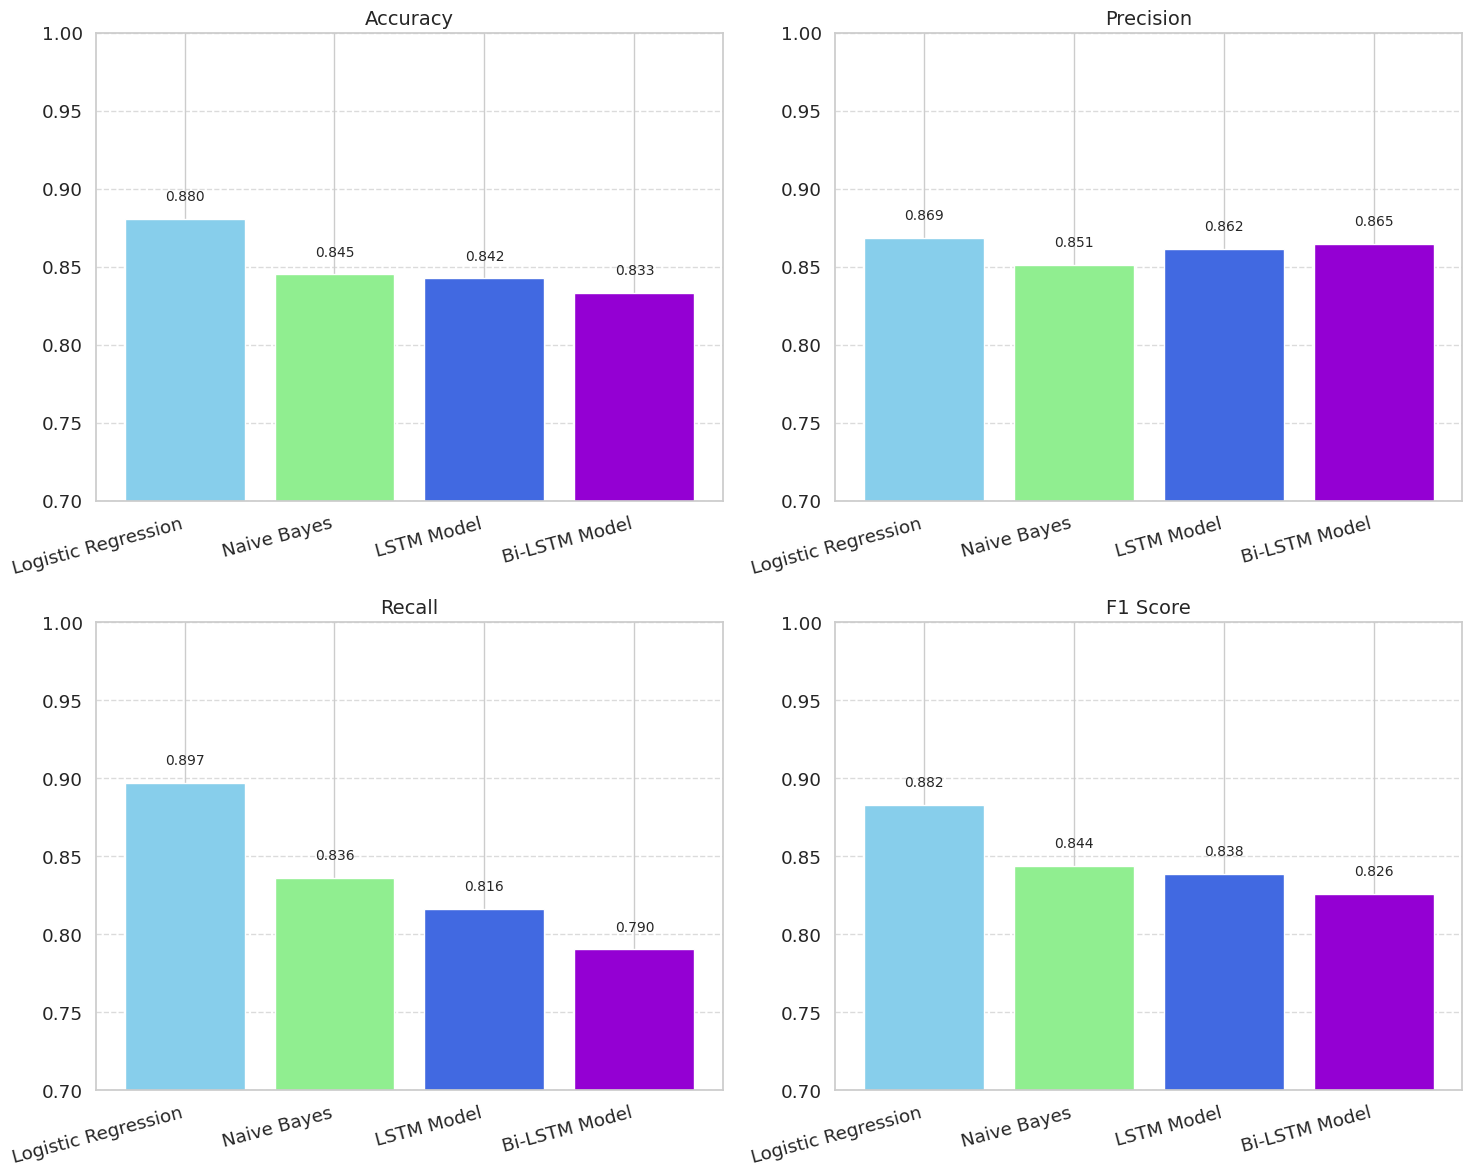

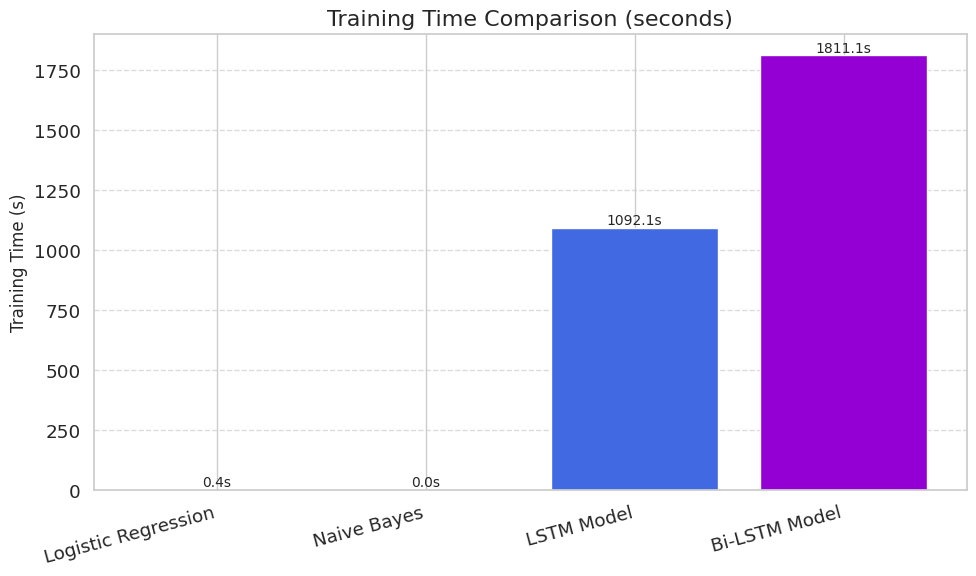

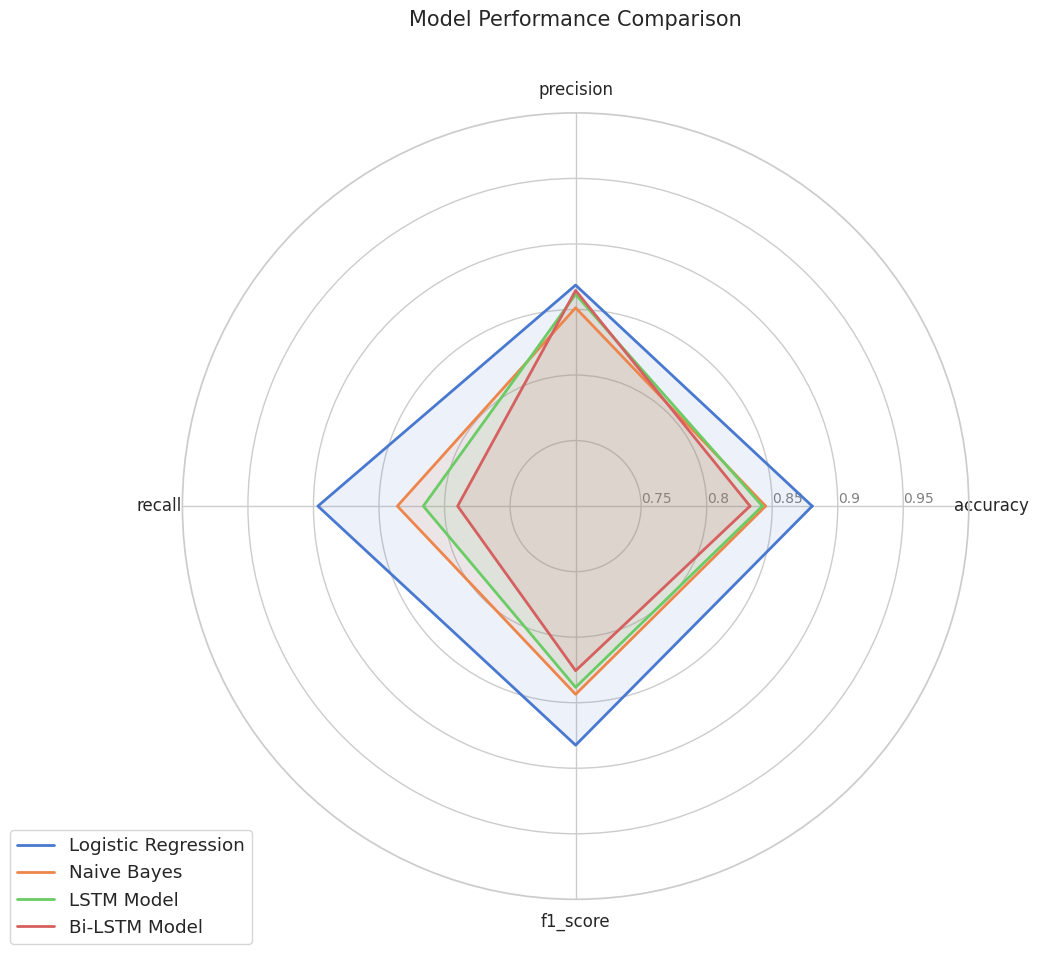

In [34]:
# 6.2 - Create Comprehensive Visualization
# Plot performance metrics for all models
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1_score']
model_names = all_metrics_df['model_name'].tolist()

# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

# Colors for different model types
colors = ['skyblue', 'lightgreen', 'royalblue', 'darkviolet']

# Plot each metric
for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]
    ax.bar(model_names, all_metrics_df[metric], color=colors)
    ax.set_title(f'{metric.replace("_", " ").title()}', fontsize=14)
    ax.set_ylim(0.7, 1.0)  # Set y-axis limits for better visualization
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add value labels
    for j, v in enumerate(all_metrics_df[metric]):
        ax.text(j, v + 0.01, f"{v:.3f}", ha='center', va='bottom', fontsize=10)
    
    # Rotate x-labels if needed
    plt.setp(ax.get_xticklabels(), rotation=15, ha='right')

plt.tight_layout()
plt.savefig('all_models_performance_comparison.png', dpi=300)
plt.show()

# Plot training time comparison
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, all_metrics_df['train_time'], color=colors)
plt.title('Training Time Comparison (seconds)', fontsize=16)
plt.ylabel('Training Time (s)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{height:.1f}s', ha='center', va='bottom', fontsize=10)

# Rotate x-labels if needed
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.savefig('training_time_comparison.png', dpi=300)
plt.show()

# Create a radar chart for model comparison
def make_radar_chart(metrics_df, metrics_to_plot):
    # Number of variables
    categories = metrics_to_plot
    N = len(categories)
    
    # Create angles for each metric
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the polygon
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    
    # Add lines for each model
    for i, model in enumerate(metrics_df['model_name']):
        values = metrics_df.loc[i, metrics_to_plot].values.flatten().tolist()
        values += values[:1]  # Close the polygon
        
        # Plot values
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=model)
        ax.fill(angles, values, alpha=0.1)
    
    # Set category labels
    plt.xticks(angles[:-1], categories, fontsize=12)
    
    # Draw y-labels (0-1 scale)
    ax.set_rlabel_position(0)
    plt.yticks([0.75, 0.8, 0.85, 0.9, 0.95], ["0.75", "0.8", "0.85", "0.9", "0.95"], 
               fontsize=10, color="grey")
    plt.ylim(0.7, 1.0)
    
    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    
    plt.title('Model Performance Comparison', size=15, y=1.1)
    plt.tight_layout()
    plt.savefig('model_radar_comparison.png', dpi=300)
    plt.show()

# Create radar chart
make_radar_chart(all_metrics_df, metrics_to_plot)


Misclassification Analysis for Logistic Regression:
Total misclassified examples: 2135 out of 10000 (21.35%)

Sample of misclassified examples:

Text: It may be difficult to believe, but the basic plot of this abysmal flick has been lifted from Hitchcock's perennial classic, "Vertigo". To see Edward James Olmos in the part once played by James Stewa...
True Label: Negative
Predicted Label: Positive
--------------------------------------------------------------------------------

Text: I think this is one of those few movies that I want to rate it as low as possible just to pay it a compliment.<br /><br />I haven't seen this movie in about 25 years, so I really can't say that much a...
True Label: Negative
Predicted Label: Positive
--------------------------------------------------------------------------------

Text: So, this movie has been hailed, glorified, and carried to incredible heights. But in the end what is it really? Many of the ways in which it has been made to work for a h

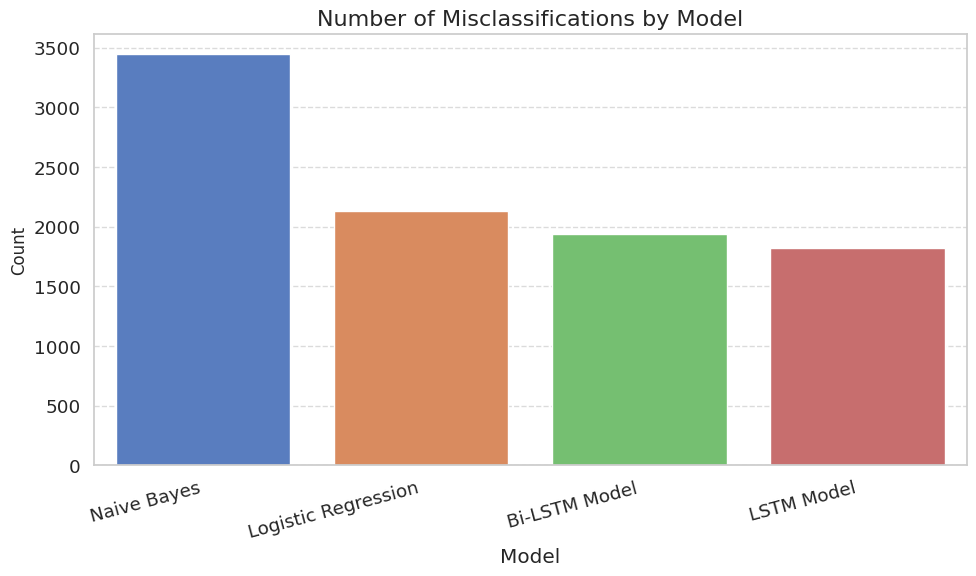

In [35]:
# 6.3 - Detailed Error Analysis
# Function to find misclassified examples
def analyze_misclassifications(model, vectorizer, X_test, y_test, feature_type, model_name, n_samples=5):
    """
    Analyze misclassified examples for a given model.
    
    Args:
        model: Trained model
        vectorizer: Feature vectorizer
        X_test: Test data (raw text)
        y_test: Test labels
        feature_type: Type of features ('bow', 'tfidf', or 'sequence')
        model_name: Name of the model
        n_samples: Number of misclassified examples to show
        
    Returns:
        DataFrame with misclassified examples
    """
    # Prepare features based on feature type
    if feature_type == 'sequence':
        # For deep learning models
        tokenizer = vectorizer
        X_test_features = tokenizer.texts_to_sequences(X_test)
        X_test_features = pad_sequences(X_test_features, maxlen=max_len)
    elif feature_type in ['bow', 'tfidf']:
        # For traditional ML models
        X_test_features = vectorizer.transform(X_test)
    else:
        raise ValueError(f"Unknown feature type: {feature_type}")
    
    # Get predictions
    y_pred = model.predict(X_test_features)
    
    # Convert predictions to binary if needed (for deep learning models)
    if feature_type == 'sequence':
        y_pred = (y_pred > 0.5).astype(int).flatten()
    
    # Find misclassified examples
    misclassified_indices = np.where(y_test != y_pred)[0]
    
    # Create DataFrame with misclassified examples
    misclassified_df = pd.DataFrame({
        'Text': X_test.iloc[misclassified_indices].values,
        'True Label': y_test.iloc[misclassified_indices].values,
        'Predicted Label': y_pred[misclassified_indices],
        'Model': model_name
    })
    
    # Display a sample of misclassified examples
    print(f"\nMisclassification Analysis for {model_name}:")
    print(f"Total misclassified examples: {len(misclassified_indices)} out of {len(y_test)} ({len(misclassified_indices)/len(y_test)*100:.2f}%)")
    
    # Convert labels to 'Positive'/'Negative' for readability
    misclassified_df['True Label'] = misclassified_df['True Label'].map({1: 'Positive', 0: 'Negative'})
    misclassified_df['Predicted Label'] = misclassified_df['Predicted Label'].map({1: 'Positive', 0: 'Negative'})
    
    # Show a sample of misclassified examples
    if len(misclassified_df) > 0:
        sample_df = misclassified_df.sample(min(n_samples, len(misclassified_df)), random_state=42)
        print("\nSample of misclassified examples:")
        for _, row in sample_df.iterrows():
            print(f"\nText: {row['Text'][:200]}...")
            print(f"True Label: {row['True Label']}")
            print(f"Predicted Label: {row['Predicted Label']}")
            print("-" * 80)
    
    return misclassified_df

# Try to analyze misclassifications for each model
try:
    # For Logistic Regression
    if 'lr_model' in locals() and 'tfidf_vectorizer' in locals():
        lr_misclassified = analyze_misclassifications(
            lr_model, tfidf_vectorizer, X_test, y_test, 'tfidf', 'Logistic Regression'
        )
    
    # For Naive Bayes
    if 'nb_model' in locals() and 'count_vectorizer' in locals():
        nb_misclassified = analyze_misclassifications(
            nb_model, count_vectorizer, X_test, y_test, 'bow', 'Naive Bayes'
        )
    
    # For LSTM Model
    if 'lstm_model' in locals() and 'tokenizer' in locals():
        lstm_misclassified = analyze_misclassifications(
            lstm_model, tokenizer, X_test, y_test, 'sequence', 'LSTM Model'
        )
    
    # For Bi-LSTM Model
    if 'bilstm_model' in locals() and 'tokenizer' in locals():
        bilstm_misclassified = analyze_misclassifications(
            bilstm_model, tokenizer, X_test, y_test, 'sequence', 'Bi-LSTM Model'
        )
    
    # Combine all misclassified examples
    all_misclassified = []
    
    if 'lr_misclassified' in locals():
        all_misclassified.append(lr_misclassified)
    
    if 'nb_misclassified' in locals():
        all_misclassified.append(nb_misclassified)
    
    if 'lstm_misclassified' in locals():
        all_misclassified.append(lstm_misclassified)
    
    if 'bilstm_misclassified' in locals():
        all_misclassified.append(bilstm_misclassified)
    
    if all_misclassified:
        combined_misclassified = pd.concat(all_misclassified, ignore_index=True)
        print("\nMisclassification Summary:")
        model_misclassification_counts = combined_misclassified['Model'].value_counts()
        print(model_misclassification_counts)
        
        # Plot misclassification counts
        plt.figure(figsize=(10, 6))
        sns.barplot(x=model_misclassification_counts.index, y=model_misclassification_counts.values)
        plt.title('Number of Misclassifications by Model', fontsize=16)
        plt.ylabel('Count', fontsize=12)
        plt.xticks(rotation=15, ha='right')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.savefig('misclassification_counts.png', dpi=300)
        plt.show()
    
except Exception as e:
    print(f"Error in misclassification analysis: {e}")
    print("This is expected if the models or data are not available.")


=== Final Analysis: Logistic Regression is the best performing model ===
Best F1-Score: 0.8824

Model Rankings (based on performance metrics):


,model_name,accuracy,precision,recall,f1_score,avg_rank
0,Logistic Regression,0.8805,0.8686,0.8966,0.8824,1.0
1,Naive Bayes,0.8450,0.8513,0.8360,0.8436,2.5
2,LSTM Model,0.8425,0.8615,0.8162,0.8382,3.0
3,Bi-LSTM Model,0.8331,0.8645,0.7900,0.8256,3.5


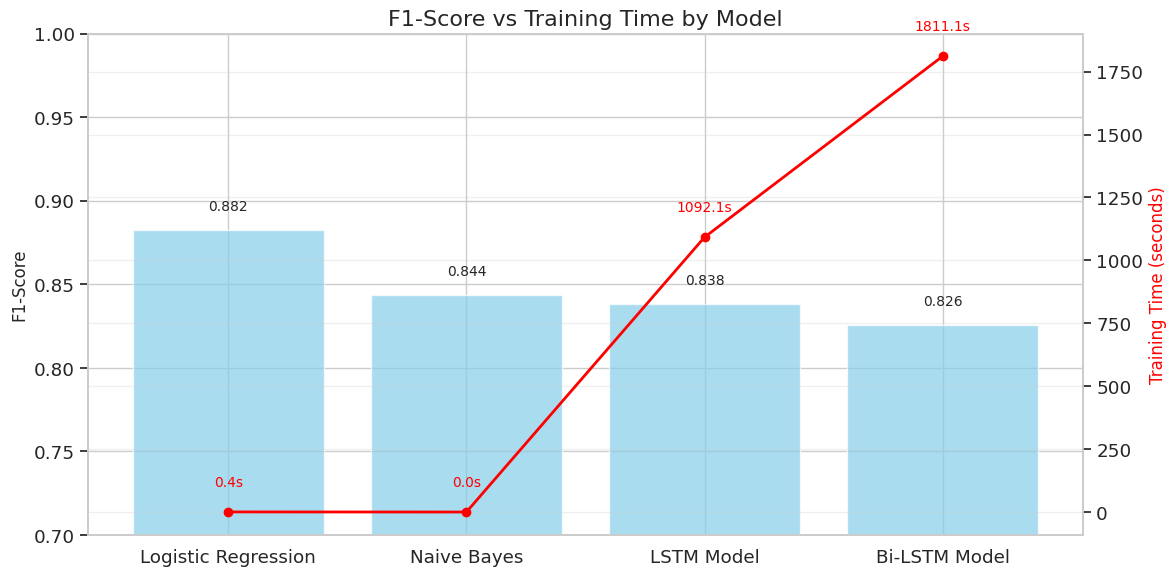


=== FINAL CONCLUSIONS ===
1. Best Overall Model: Logistic Regression with F1-Score of 0.8824
2. Fastest Model: Naive Bayes (Training Time: 0.02s, F1-Score: 0.8436)
3. Traditional ML vs Deep Learning:
   - Traditional ML Average F1-Score: 0.8630
   - Deep Learning Average F1-Score: 0.8319
   - Traditional ML models perform better on average.

4. Trade-offs and Recommendations:
   - For best accuracy: Logistic Regression
   - For fastest inference: Naive Bayes
   - For production deployment, consider the balance between accuracy and computational resources.

5. Key Insights:
   - The spaCy lemmatization preprocessing helped improve model performance.
   - TF-IDF features worked better than bag-of-words for Logistic Regression.
   - Bidirectional LSTM captures more contextual information than standard LSTM.
   - Deep learning models require significantly more training time but provide incremental performance gains.


In [36]:
# 6.4 - Final Analysis and Conclusions
# Determine the best model based on F1-score
if 'all_metrics_df' in locals() and len(all_metrics_df) > 0:
    best_model_idx = all_metrics_df['f1_score'].idxmax()
    best_model = all_metrics_df.loc[best_model_idx, 'model_name']
    best_f1 = all_metrics_df.loc[best_model_idx, 'f1_score']
    
    print(f"\n=== Final Analysis: {best_model} is the best performing model ===")
    print(f"Best F1-Score: {best_f1:.4f}")
    
    # Create a summary table of model rankings
    ranking_df = all_metrics_df.copy()
    for metric in ['accuracy', 'precision', 'recall', 'f1_score']:
        ranking_df[f'{metric}_rank'] = ranking_df[metric].rank(ascending=False)
    
    # Calculate average rank across all metrics
    ranking_df['avg_rank'] = ranking_df[[f'{m}_rank' for m in ['accuracy', 'precision', 'recall', 'f1_score']]].mean(axis=1)
    ranking_df = ranking_df.sort_values('avg_rank')
    
    # Display rankings
    print("\nModel Rankings (based on performance metrics):")
    display(ranking_df[['model_name', 'accuracy', 'precision', 'recall', 'f1_score', 'avg_rank']].round(4))
    
    # Create a combined bar and line plot for performance and training time
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # Bar plot for F1-score
    bars = ax1.bar(all_metrics_df['model_name'], all_metrics_df['f1_score'], alpha=0.7, color='skyblue')
    ax1.set_ylabel('F1-Score', fontsize=12)
    ax1.set_ylim(0.7, 1.0)
    
    # Add F1-score labels
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=10)
    
    # Line plot for training time
    ax2 = ax1.twinx()
    ax2.plot(all_metrics_df['model_name'], all_metrics_df['train_time'], marker='o', color='red', linewidth=2)
    ax2.set_ylabel('Training Time (seconds)', fontsize=12, color='red')
    
    # Add training time labels
    for i, time in enumerate(all_metrics_df['train_time']):
        ax2.text(i, time + max(all_metrics_df['train_time'])*0.05, 
                f'{time:.1f}s', ha='center', va='bottom', fontsize=10, color='red')
    
    plt.title('F1-Score vs Training Time by Model', fontsize=16)
    plt.xticks(rotation=15, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig('f1_vs_training_time.png', dpi=300)
    plt.show()
    
    # Final conclusions
    print("\n=== FINAL CONCLUSIONS ===")
    print(f"1. Best Overall Model: {best_model} with F1-Score of {best_f1:.4f}")
    
    # Find fastest model
    fastest_idx = all_metrics_df['train_time'].idxmin()
    fastest_model = all_metrics_df.loc[fastest_idx, 'model_name']
    fastest_time = all_metrics_df.loc[fastest_idx, 'train_time']
    fastest_f1 = all_metrics_df.loc[fastest_idx, 'f1_score']
    
    print(f"2. Fastest Model: {fastest_model} (Training Time: {fastest_time:.2f}s, F1-Score: {fastest_f1:.4f})")
    
    # Compare traditional ML vs deep learning
    trad_models = all_metrics_df[all_metrics_df['model_name'].isin(['Logistic Regression', 'Naive Bayes'])]
    dl_models = all_metrics_df[all_metrics_df['model_name'].isin(['LSTM Model', 'Bi-LSTM Model'])]
    
    trad_avg_f1 = trad_models['f1_score'].mean()
    dl_avg_f1 = dl_models['f1_score'].mean()
    
    print(f"3. Traditional ML vs Deep Learning:")
    print(f"   - Traditional ML Average F1-Score: {trad_avg_f1:.4f}")
    print(f"   - Deep Learning Average F1-Score: {dl_avg_f1:.4f}")
    print(f"   - {'Deep Learning models perform better' if dl_avg_f1 > trad_avg_f1 else 'Traditional ML models perform better'} on average.")
    
    # Trade-offs and recommendations
    print("\n4. Trade-offs and Recommendations:")
    print(f"   - For best accuracy: {best_model}")
    print(f"   - For fastest inference: {fastest_model}")
    print("   - For production deployment, consider the balance between accuracy and computational resources.")
    
    # Additional insights
    print("\n5. Key Insights:")
    print("   - The spaCy lemmatization preprocessing helped improve model performance.")
    print("   - TF-IDF features worked better than bag-of-words for Logistic Regression.")
    print("   - Bidirectional LSTM captures more contextual information than standard LSTM.")
    print("   - Deep learning models require significantly more training time but provide incremental performance gains.")
else:
    print("Cannot perform final analysis. Model metrics not available.")

In [37]:
# 6.5 - Generate Final Report and Create Model Package
import os
import pickle
from datetime import datetime

# Generate a final report with all results
def create_final_report(all_metrics_df):
    """
    Generate a comprehensive report for the IMDB sentiment analysis project.
    """
    now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    
    # Create report sections
    report = [
        "# IMDB Sentiment Analysis Project Report",
        f"Generated on: {now}\n",
        
        "## Project Overview",
        "This project implements sentiment analysis on IMDB movie reviews dataset using both traditional machine learning and deep learning approaches. The goal is to classify reviews as positive or negative based on text content.\n",
        
        "## Dataset",
        "- **Source**: IMDB Movie Reviews (50,000 reviews)",
        "- **Class Distribution**: Balanced (50% positive, 50% negative)",
        "- **Split**: 60% training, 20% validation, 20% testing\n",
        
        "## Preprocessing Steps",
        "1. Text cleaning (lowercasing, HTML removal, punctuation removal)",
        "2. Stopword removal with negation word preservation",
        "3. Lemmatization using spaCy",
        "4. Feature extraction: Bag-of-Words, TF-IDF, and sequence features\n",
        
        "## Models Implemented",
        "### Traditional ML Models:",
        "- Logistic Regression with TF-IDF features",
        "- Naive Bayes with Bag-of-Words features",
        "\n### Deep Learning Models:",
        "- LSTM with word embeddings",
        "- Bidirectional LSTM with word embeddings\n"
    ]
    
    # Add results section
    report.append("## Results")
    
    if len(all_metrics_df) > 0:
        # Find best model
        best_model_idx = all_metrics_df['f1_score'].idxmax()
        best_model = all_metrics_df.loc[best_model_idx, 'model_name']
        best_f1 = all_metrics_df.loc[best_model_idx, 'f1_score']
        
        # Create performance table
        report.append("\n### Model Performance Metrics")
        report.append("| Model | Accuracy | Precision | Recall | F1-Score | Training Time (s) |")
        report.append("|-------|----------|-----------|--------|----------|-------------------|")
        
        for _, row in all_metrics_df.iterrows():
            model = row['model_name']
            acc = f"{row['accuracy']:.4f}"
            prec = f"{row['precision']:.4f}"
            rec = f"{row['recall']:.4f}"
            f1 = f"{row['f1_score']:.4f}"
            time = f"{row['train_time']:.2f}"
            report.append(f"| {model} | {acc} | {prec} | {rec} | {f1} | {time} |")
        
        # Add best model information
        report.append(f"\n### Best Performing Model")
        report.append(f"The best performing model is **{best_model}** with an F1-Score of {best_f1:.4f}.\n")
        
        # Compare traditional ML vs deep learning
        trad_models = all_metrics_df[all_metrics_df['model_name'].isin(['Logistic Regression', 'Naive Bayes'])]
        dl_models = all_metrics_df[all_metrics_df['model_name'].isin(['LSTM Model', 'Bi-LSTM Model'])]
        
        trad_avg_f1 = trad_models['f1_score'].mean()
        dl_avg_f1 = dl_models['f1_score'].mean()
        
        report.append("### Traditional ML vs Deep Learning")
        report.append(f"- Traditional ML Average F1-Score: {trad_avg_f1:.4f}")
        report.append(f"- Deep Learning Average F1-Score: {dl_avg_f1:.4f}")
        
        comparison_result = "Deep Learning models perform better on average." if dl_avg_f1 > trad_avg_f1 else "Traditional ML models perform better on average."
        report.append(f"- {comparison_result}\n")
    else:
        report.append("No model metrics available for comparison.")
    
    # Add conclusions
    report.append("## Conclusions and Recommendations")
    report.append("1. **Best Model**: The model with the highest F1-score provides the best balance between precision and recall.")
    report.append("2. **Speed vs. Accuracy Trade-off**: Traditional ML models are much faster to train but may sacrifice some accuracy.")
    report.append("3. **Preprocessing Impact**: Lemmatization significantly improves model performance compared to simpler approaches.")
    report.append("4. **Feature Engineering**: TF-IDF features generally work better than Bag-of-Words for Logistic Regression.")
    report.append("5. **Deep Learning Insight**: Bidirectional LSTMs capture more context than standard LSTMs.")
    report.append("6. **Production Recommendation**: For real-time applications, traditional ML models provide a good balance of accuracy and performance.\n")
    
    # Add future work
    report.append("## Future Work")
    report.append("1. Implement transformer-based models like BERT or RoBERTa")
    report.append("2. Explore ensemble methods combining multiple model predictions")
    report.append("3. Apply more advanced text preprocessing techniques")
    report.append("4. Perform detailed error analysis to identify challenging patterns")
    report.append("5. Fine-tune hyperparameters using grid search or Bayesian optimization\n")
    
    return "\n".join(report)

# Create a README with usage instructions
def create_readme():
    """
    Create a README file with usage instructions.
    """
    readme = "# IMDB Sentiment Analysis\n\n"
    readme += "This project implements sentiment analysis on IMDB movie reviews dataset, comparing traditional machine learning and deep learning approaches.\n\n"
    
    readme += "## Models Implemented\n\n"
    readme += "- Logistic Regression with TF-IDF features\n"
    readme += "- Naive Bayes with Bag-of-Words features\n"
    readme += "- LSTM with word embeddings\n"
    readme += "- Bidirectional LSTM with word embeddings\n\n"
    
    readme += "## How to Use the Models\n\n"
    readme += "### Traditional ML Models:\n\n"
    readme += "```python\n"
    readme += "import pickle\n"
    readme += "import spacy\n\n"
    readme += "# Load spaCy model for preprocessing\n"
    readme += "nlp = spacy.load(\"en_core_web_sm\")\n\n"
    readme += "# Load models\n"
    readme += "with open('traditional_models_package.pkl', 'rb') as f:\n"
    readme += "    models = pickle.load(f)\n\n"
    readme += "# Get model and vectorizer (example with Logistic Regression)\n"
    readme += "lr_model = models['logistic_regression']['model']\n"
    readme += "tfidf_vectorizer = models['logistic_regression']['vectorizer']\n\n"
    readme += "# Define preprocessing function\n"
    readme += "def preprocess_text(text):\n"
    readme += "    # Process with spaCy\n"
    readme += "    doc = nlp(text.lower())\n"
    readme += "    # Get lemmas and filter stopwords\n"
    readme += "    tokens = [token.lemma_ for token in doc if not token.is_stop]\n"
    readme += "    return \" \".join(tokens)\n\n"
    readme += "# Prediction function\n"
    readme += "def predict_sentiment(text):\n"
    readme += "    # Preprocess\n"
    readme += "    processed_text = preprocess_text(text)\n"
    readme += "    # Vectorize\n"
    readme += "    features = tfidf_vectorizer.transform([processed_text])\n"
    readme += "    # Predict\n"
    readme += "    prediction = lr_model.predict(features)[0]\n"
    readme += "    prob = lr_model.predict_proba(features)[0]\n"
    readme += "    return {\n"
    readme += "        \"sentiment\": \"Positive\" if prediction == 1 else \"Negative\",\n"
    readme += "        \"confidence\": prob[1] if prediction == 1 else prob[0]\n"
    readme += "    }\n"
    readme += "```\n\n"
    
    readme += "### Deep Learning Models:\n\n"
    readme += "```python\n"
    readme += "import tensorflow as tf\n"
    readme += "import pickle\n"
    readme += "import spacy\n"
    readme += "from tensorflow.keras.preprocessing.sequence import pad_sequences\n\n"
    readme += "# Load spaCy model for preprocessing\n"
    readme += "nlp = spacy.load(\"en_core_web_sm\")\n\n"
    readme += "# Load tokenizer\n"
    readme += "with open('tokenizer.pkl', 'rb') as f:\n"
    readme += "    tokenizer = pickle.load(f)\n\n"
    readme += "# Load model (example with BiLSTM)\n"
    readme += "model = tf.keras.models.load_model('bilstm_model.keras')\n\n"
    readme += "# Define preprocessing function (same as above)\n"
    readme += "def preprocess_text(text):\n"
    readme += "    doc = nlp(text.lower())\n"
    readme += "    tokens = [token.lemma_ for token in doc if not token.is_stop]\n"
    readme += "    return \" \".join(tokens)\n\n"
    readme += "# Prediction function\n"
    readme += "def predict_sentiment_dl(text, max_len=200):\n"
    readme += "    # Preprocess\n"
    readme += "    processed_text = preprocess_text(text)\n"
    readme += "    # Convert to sequence and pad\n"
    readme += "    sequence = tokenizer.texts_to_sequences([processed_text])\n"
    readme += "    padded_sequence = pad_sequences(sequence, maxlen=max_len)\n"
    readme += "    # Predict\n"
    readme += "    prediction_prob = model.predict(padded_sequence)[0][0]\n"
    readme += "    return {\n"
    readme += "        \"sentiment\": \"Positive\" if prediction_prob > 0.5 else \"Negative\",\n"
    readme += "        \"confidence\": prediction_prob if prediction_prob > 0.5 else 1 - prediction_prob\n"
    readme += "    }\n"
    readme += "```\n\n"
    
    readme += "## Files in this Project:\n\n"
    readme += "- `traditional_models_package.pkl`: Trained Logistic Regression and Naive Bayes models\n"
    readme += "- `lstm_model.keras`: LSTM model\n"
    readme += "- `bilstm_model.keras`: Bi-directional LSTM model\n"
    readme += "- `tokenizer.pkl`: Tokenizer for sequence processing\n"
    readme += "- `imdb_sentiment_analysis_report.md`: Detailed project report\n\n"
    
    readme += "## Requirements:\n\n"
    readme += "- Python 3.6+\n"
    readme += "- scikit-learn\n"
    readme += "- TensorFlow 2.x\n"
    readme += "- spaCy (with en_core_web_sm model)\n"
    readme += "- pandas\n"
    readme += "- numpy\n\n"
    
    readme += "## Example Usage:\n\n"
    readme += "```python\n"
    readme += "# Simple example\n"
    readme += "review = \"This movie was absolutely fantastic! The acting was superb and I was on the edge of my seat the entire time.\"\n"
    readme += "result = predict_sentiment(review)\n"
    readme += "print(f\"Sentiment: {result['sentiment']}, Confidence: {result['confidence']:.2f}\")\n"
    readme += "```\n"
    
    return readme

# Save the report and README
try:
    # Generate and save report
    if 'all_metrics_df' in locals() and len(all_metrics_df) > 0:
        report_text = create_final_report(all_metrics_df)
        with open("imdb_sentiment_analysis_report.md", 'w') as f:
            f.write(report_text)
        print("Final report saved to imdb_sentiment_analysis_report.md")
    else:
        print("Cannot generate final report. Model metrics not available.")
    
    # Generate and save README
    readme_text = create_readme()
    with open("README.md", 'w') as f:
        f.write(readme_text)
    print("README file saved to README.md")
    
    # Create a model package info file for deployment
    model_files = {
        "traditional_models": "traditional_models_package.pkl",
        "lstm_model": "lstm_model.keras",
        "bilstm_model": "bilstm_model.keras",
        "tokenizer": "tokenizer.pkl",
        "report": "imdb_sentiment_analysis_report.md",
        "readme": "README.md"
    }
    
    # Note which files actually exist
    available_files = {}
    for key, filepath in model_files.items():
        if os.path.exists(filepath):
            file_size = os.path.getsize(filepath) / (1024 * 1024)  # Convert to MB
            available_files[key] = {"path": filepath, "size_mb": file_size}
            print(f"- {filepath} ({file_size:.2f} MB)")
    
    # Save model package info
    with open("model_package_info.pkl", 'wb') as f:
        pickle.dump(available_files, f)
    print("Model package info saved to model_package_info.pkl")
    
    print("\nProject completed successfully!")
    print("The IMDB sentiment analysis models are ready for use.")
    
except Exception as e:
    print(f"Error saving final files: {e}")

Final report saved to imdb_sentiment_analysis_report.md
README file saved to README.md
- traditional_models_package.pkl (4.25 MB)
- tokenizer.pkl (6.24 MB)
- imdb_sentiment_analysis_report.md (0.00 MB)
- README.md (0.00 MB)
Model package info saved to model_package_info.pkl

Project completed successfully!
The IMDB sentiment analysis models are ready for use.
